### See if feature decoding is affected by whether feature is selected next trial

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.kfold_block_splitter import KFoldBlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 14})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

### Setup

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

### Helper Function

In [3]:
def train_model(feature_dim, firing_rates, feature_selections, pre_int, post_int, bin_size, name, event_name, splitter=None, splitter_name=None):
    num_neurons = len(firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(labels)}
    # init_params = {"n_inputs": num_neurons, "n_values": 12}

    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
    wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, labels)
    # wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})
    if splitter is None:
        splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)
        splitter_name = "random_split"
    outputs = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, (pre_int + post_int) / 1000, bin_size / 1000), splitter
    )
    io_utils.save_model_outputs(
        name, 
        f"{pre_int}_{event_name}_{post_int}",
        splitter_name,
        outputs
    )

### Firing rates, feature selections

In [4]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_1300_FeedbackOnset_1500_100_bins.pickle")
firing_rates = firing_rates[firing_rates.TrialNumber.isin(valid_beh.TrialNumber)]

In [5]:
feature_selections = behavioral_utils.get_selection_features(valid_beh)

### Replot feature decoding

In [ ]:
for feature_dim in feature_dims:
    num_neurons = len(firing_rates.UnitID.unique())
    labels = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(labels)}
    trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
    wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, labels)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    outputs = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.05), random_splitter
    )
    io_utils.save_model_outputs(
        feature_dim, 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
        outputs
    )

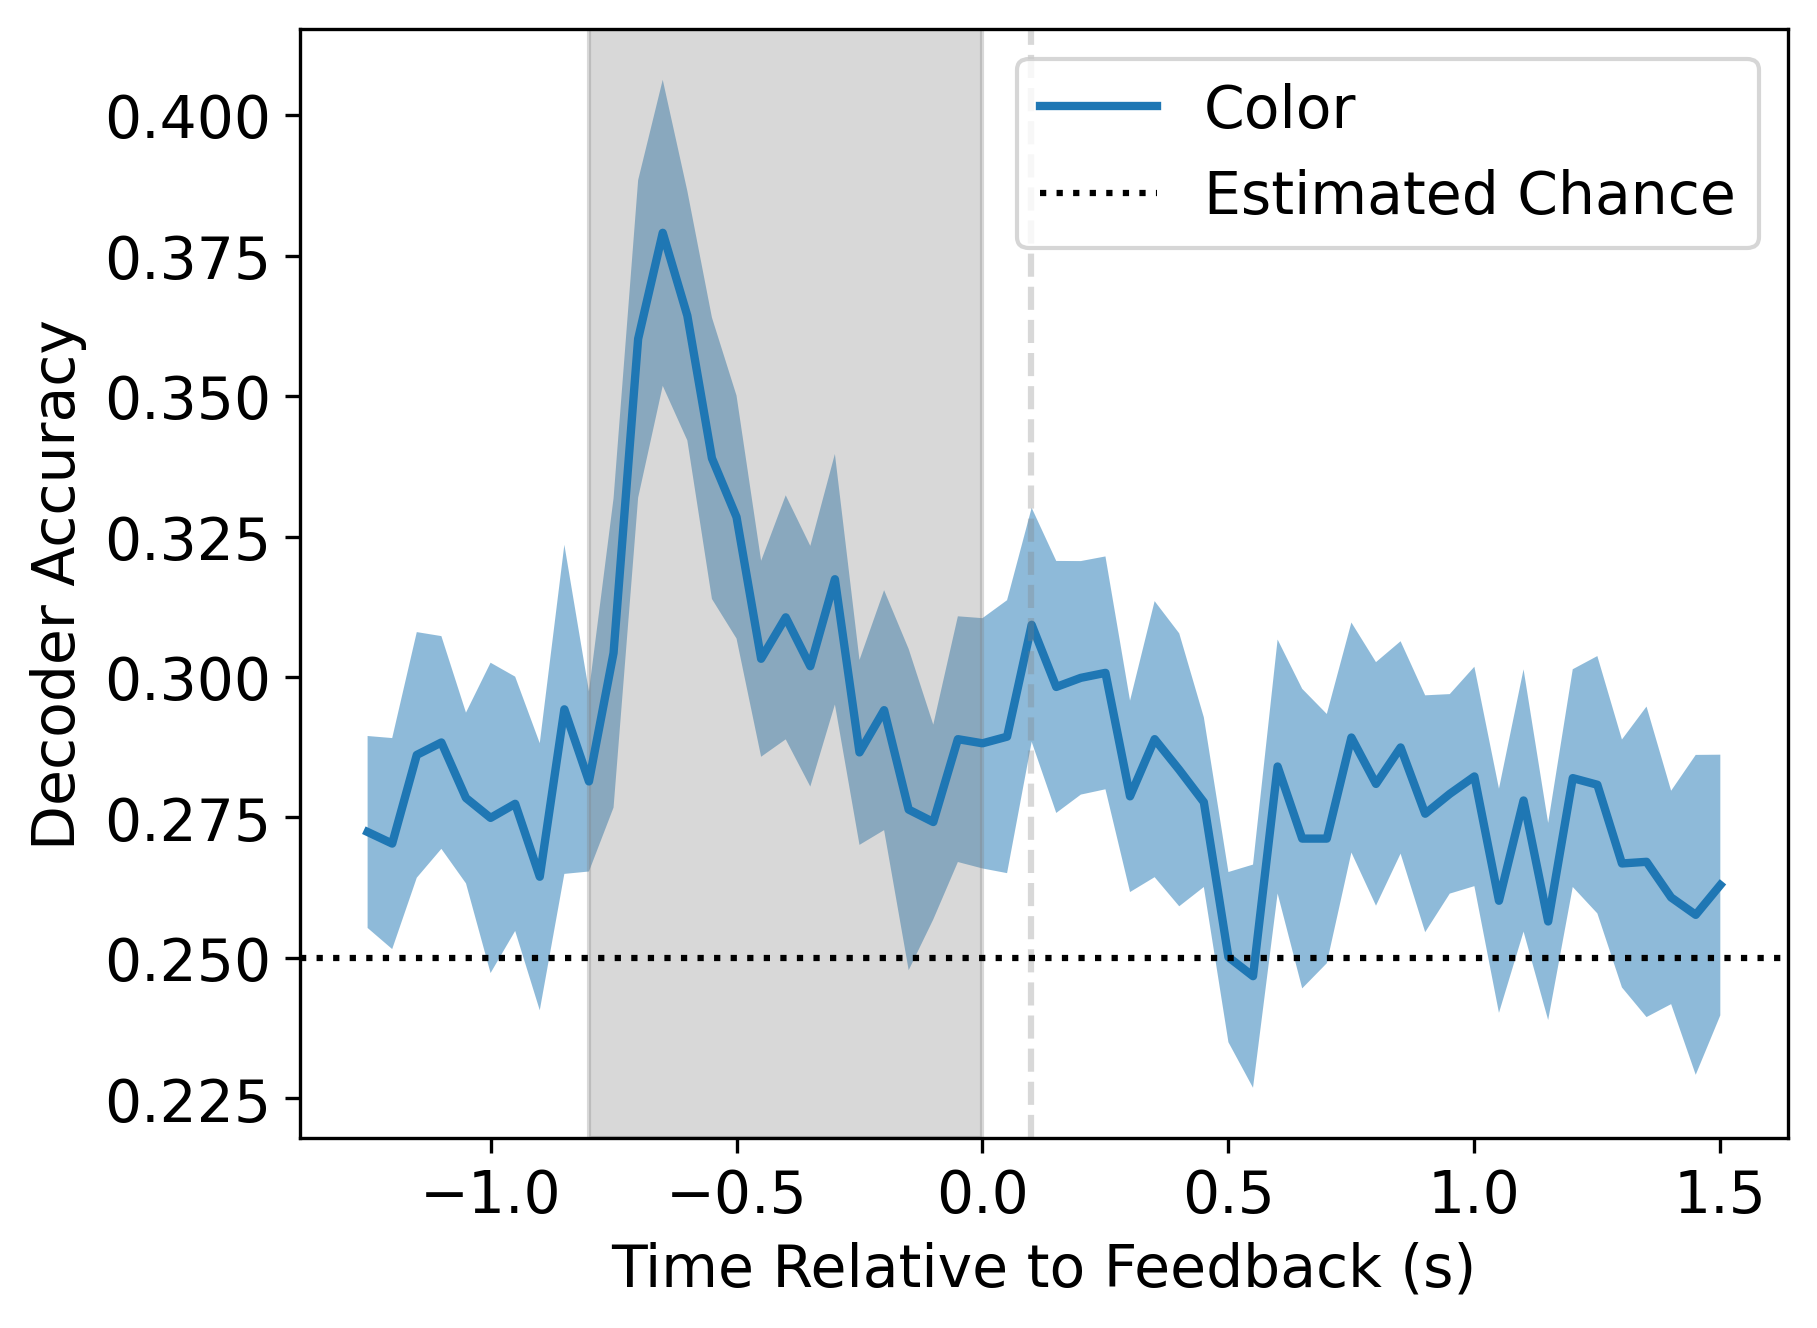

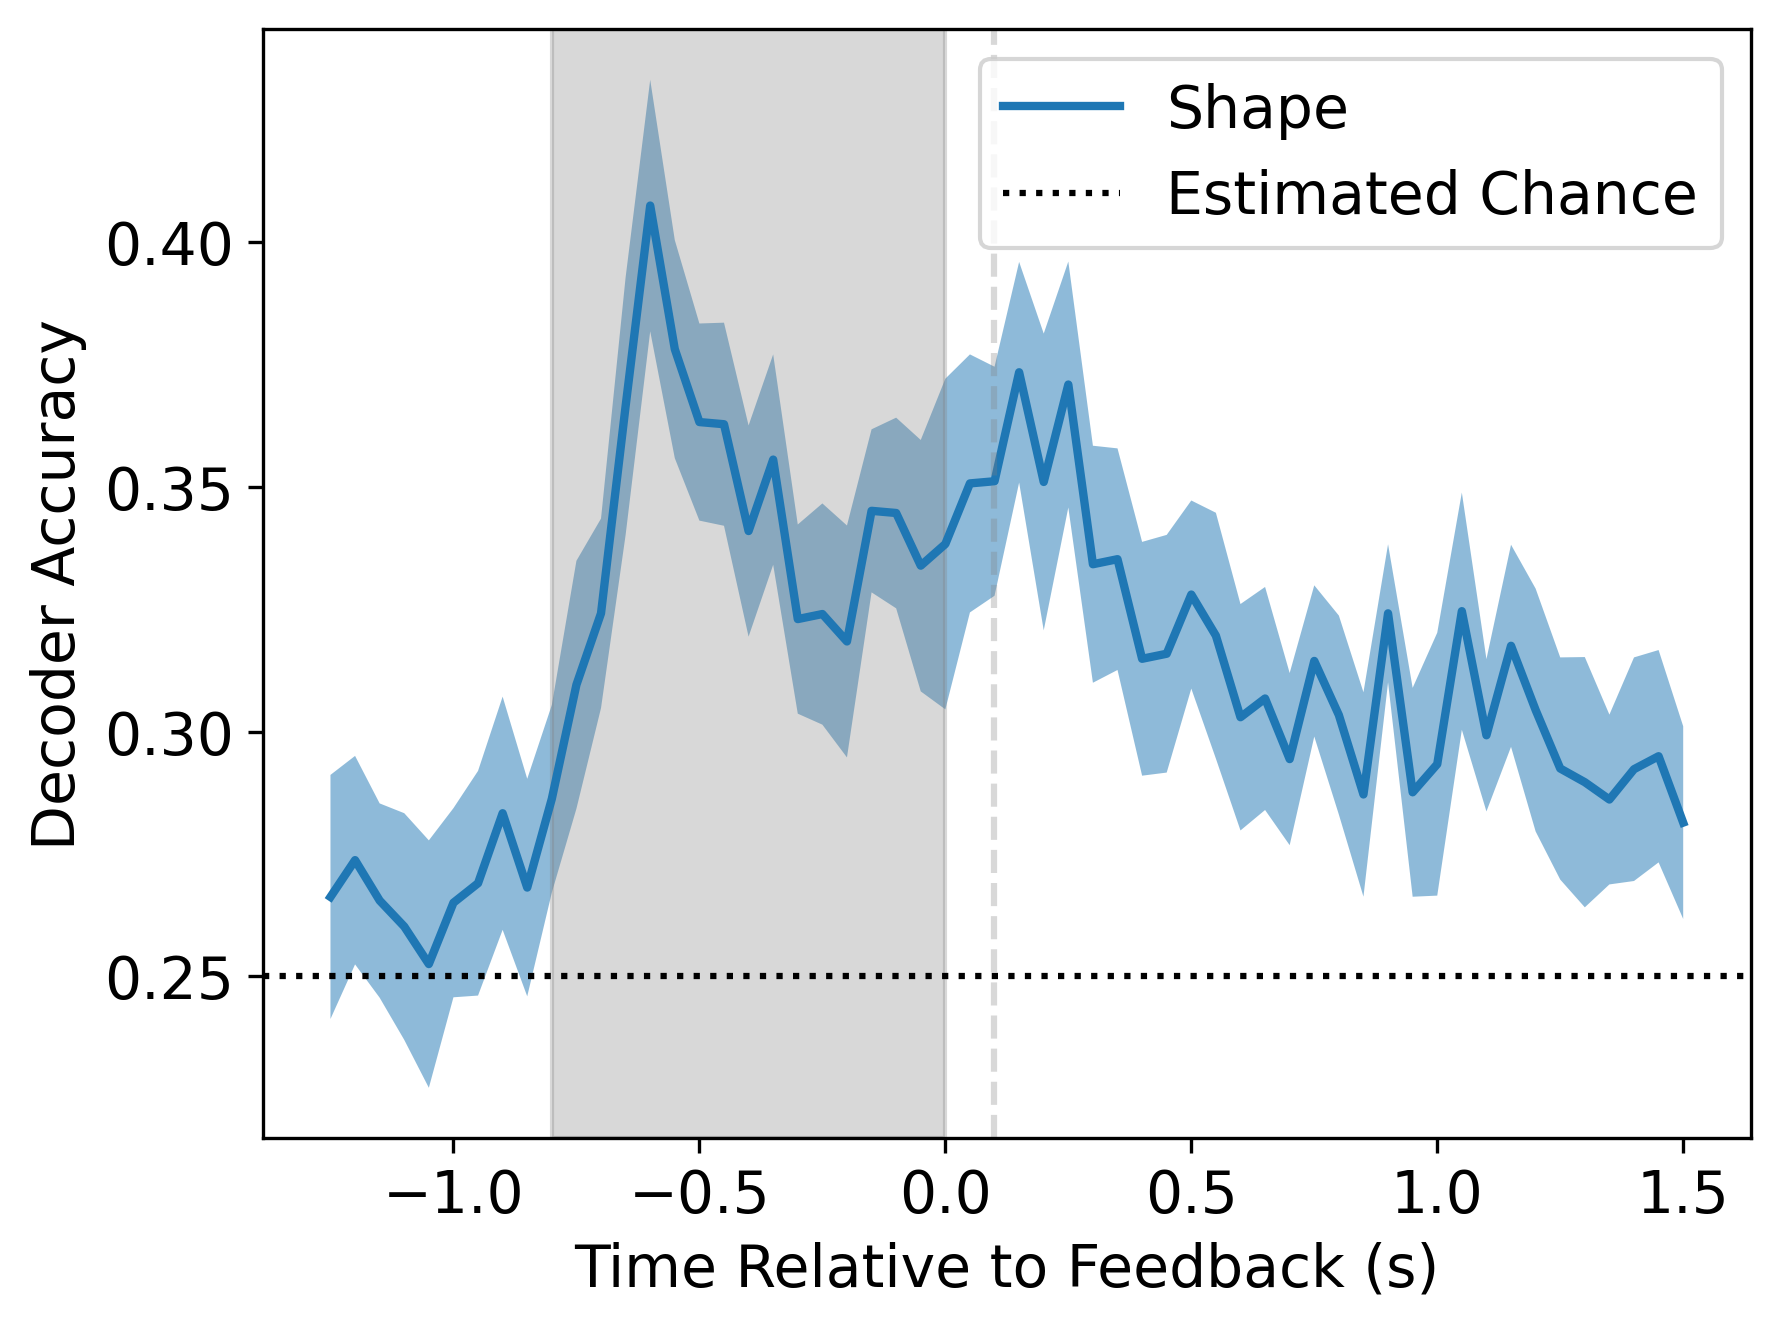

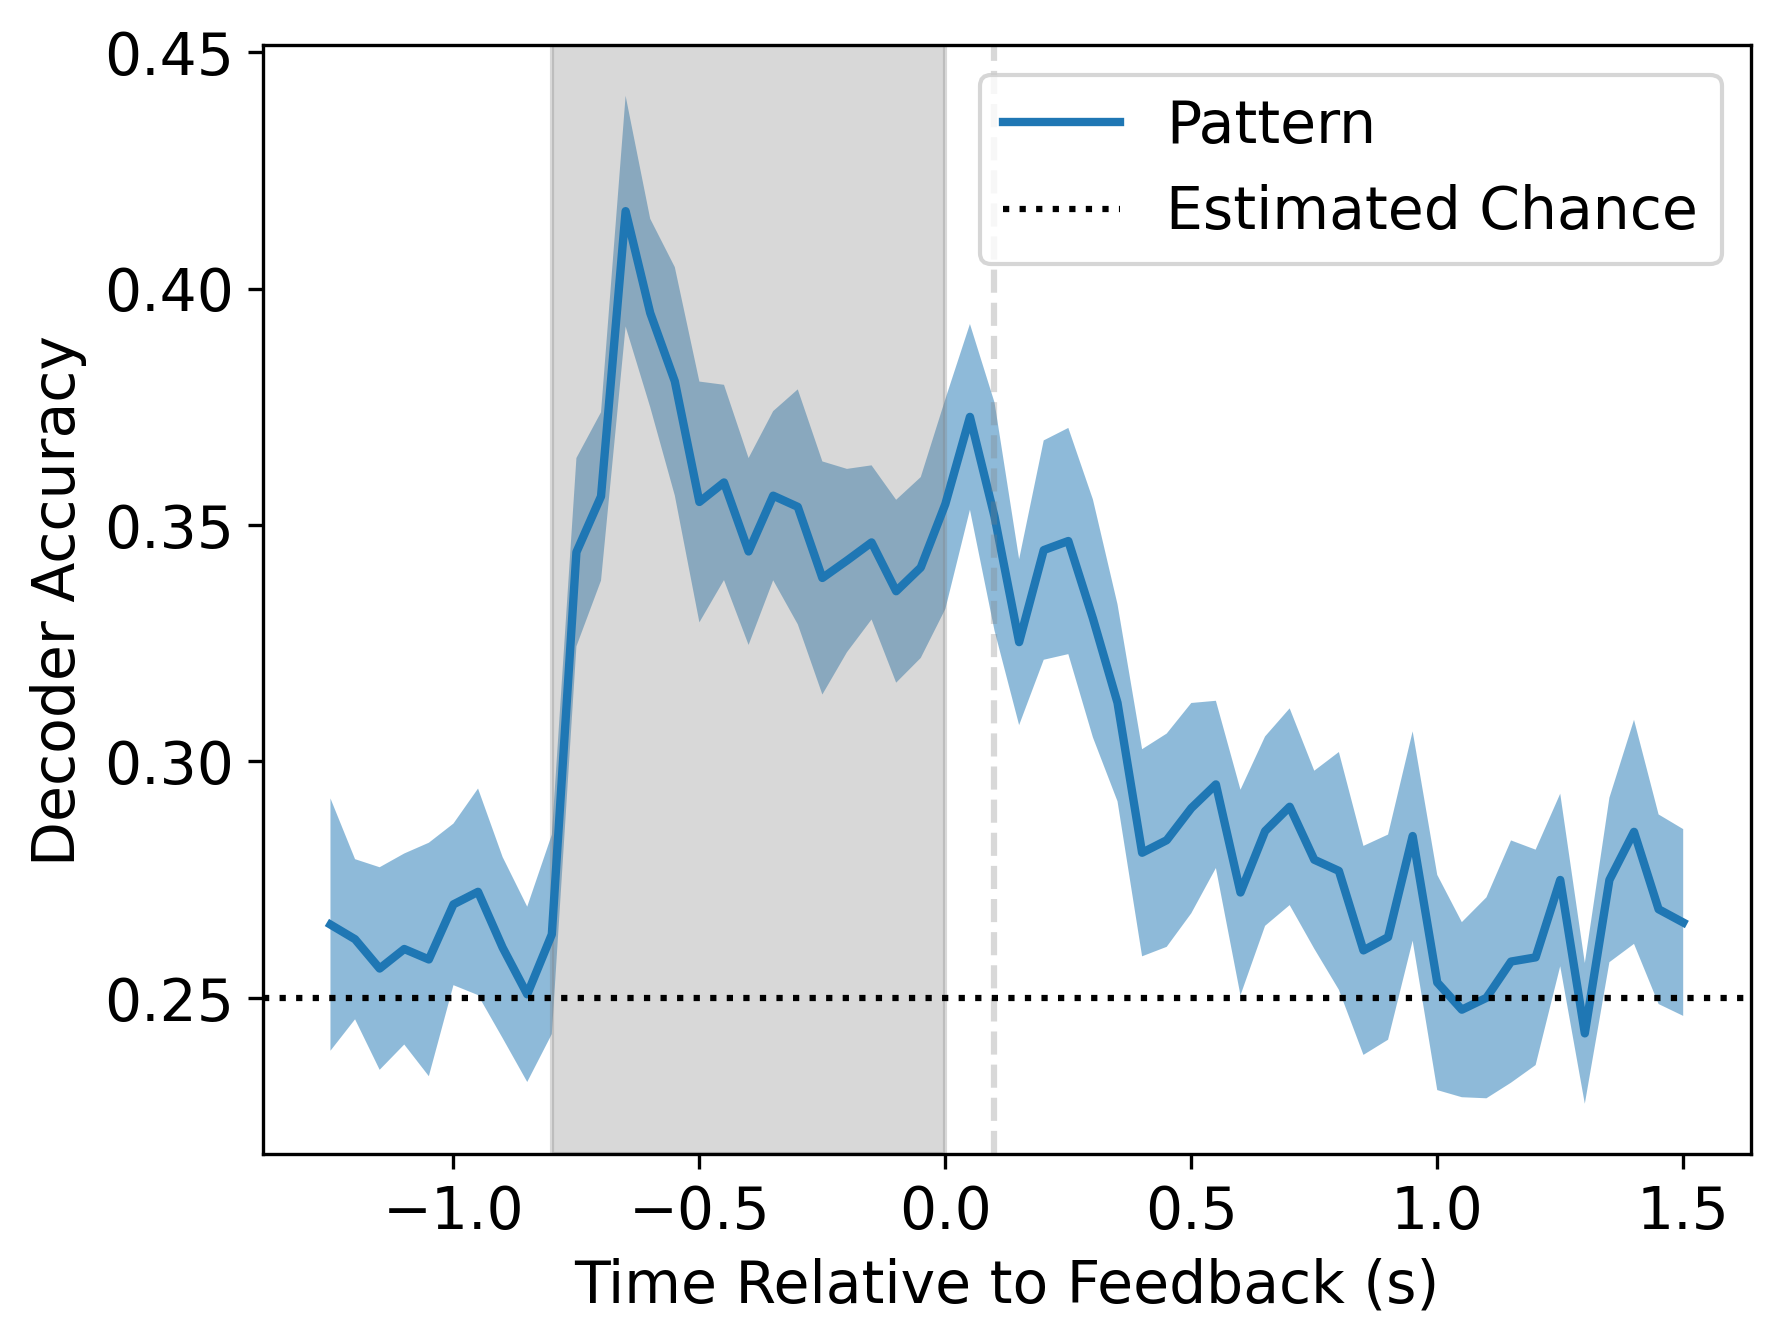

In [8]:
for feature_dim in feature_dims:
    _, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
        feature_dim, 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        1.3, 1.5, 0.05,
        ax,
        label=feature_dim,
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Go back to 100ms bins and see if there's a difference

In [4]:
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_1300_FeedbackOnset_1500_100_bins.pickle")
firing_rates = firing_rates[firing_rates.TrialNumber.isin(valid_beh.TrialNumber)]

In [5]:
feature_selections = behavioral_utils.get_selection_features(valid_beh)

In [ ]:
for feature_dim in feature_dims:
    train_model(feature_dim, firing_rates, feature_selections, 1300, 1500, 100, feature_dim, "fb", splitter=None, splitter_name=None)

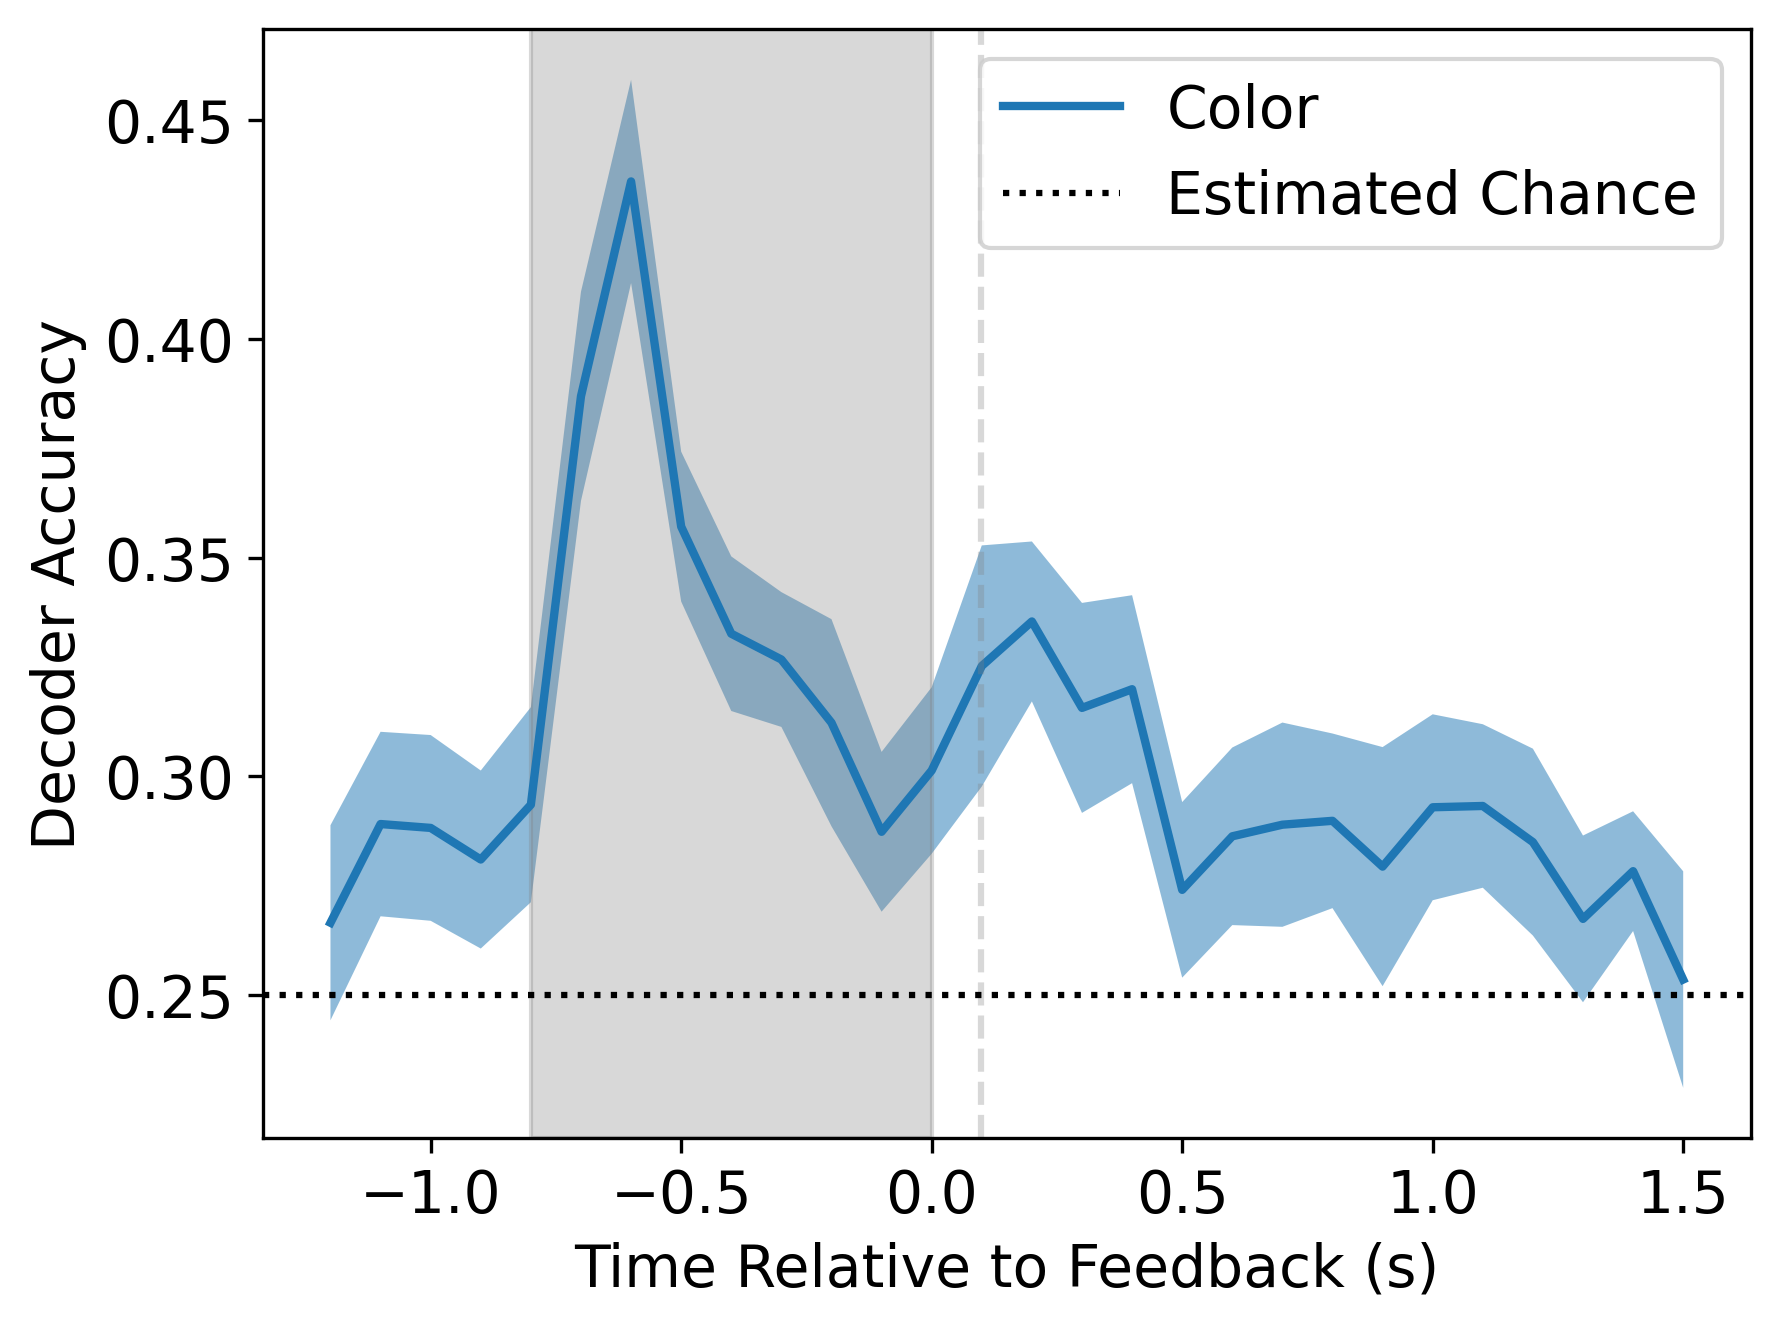

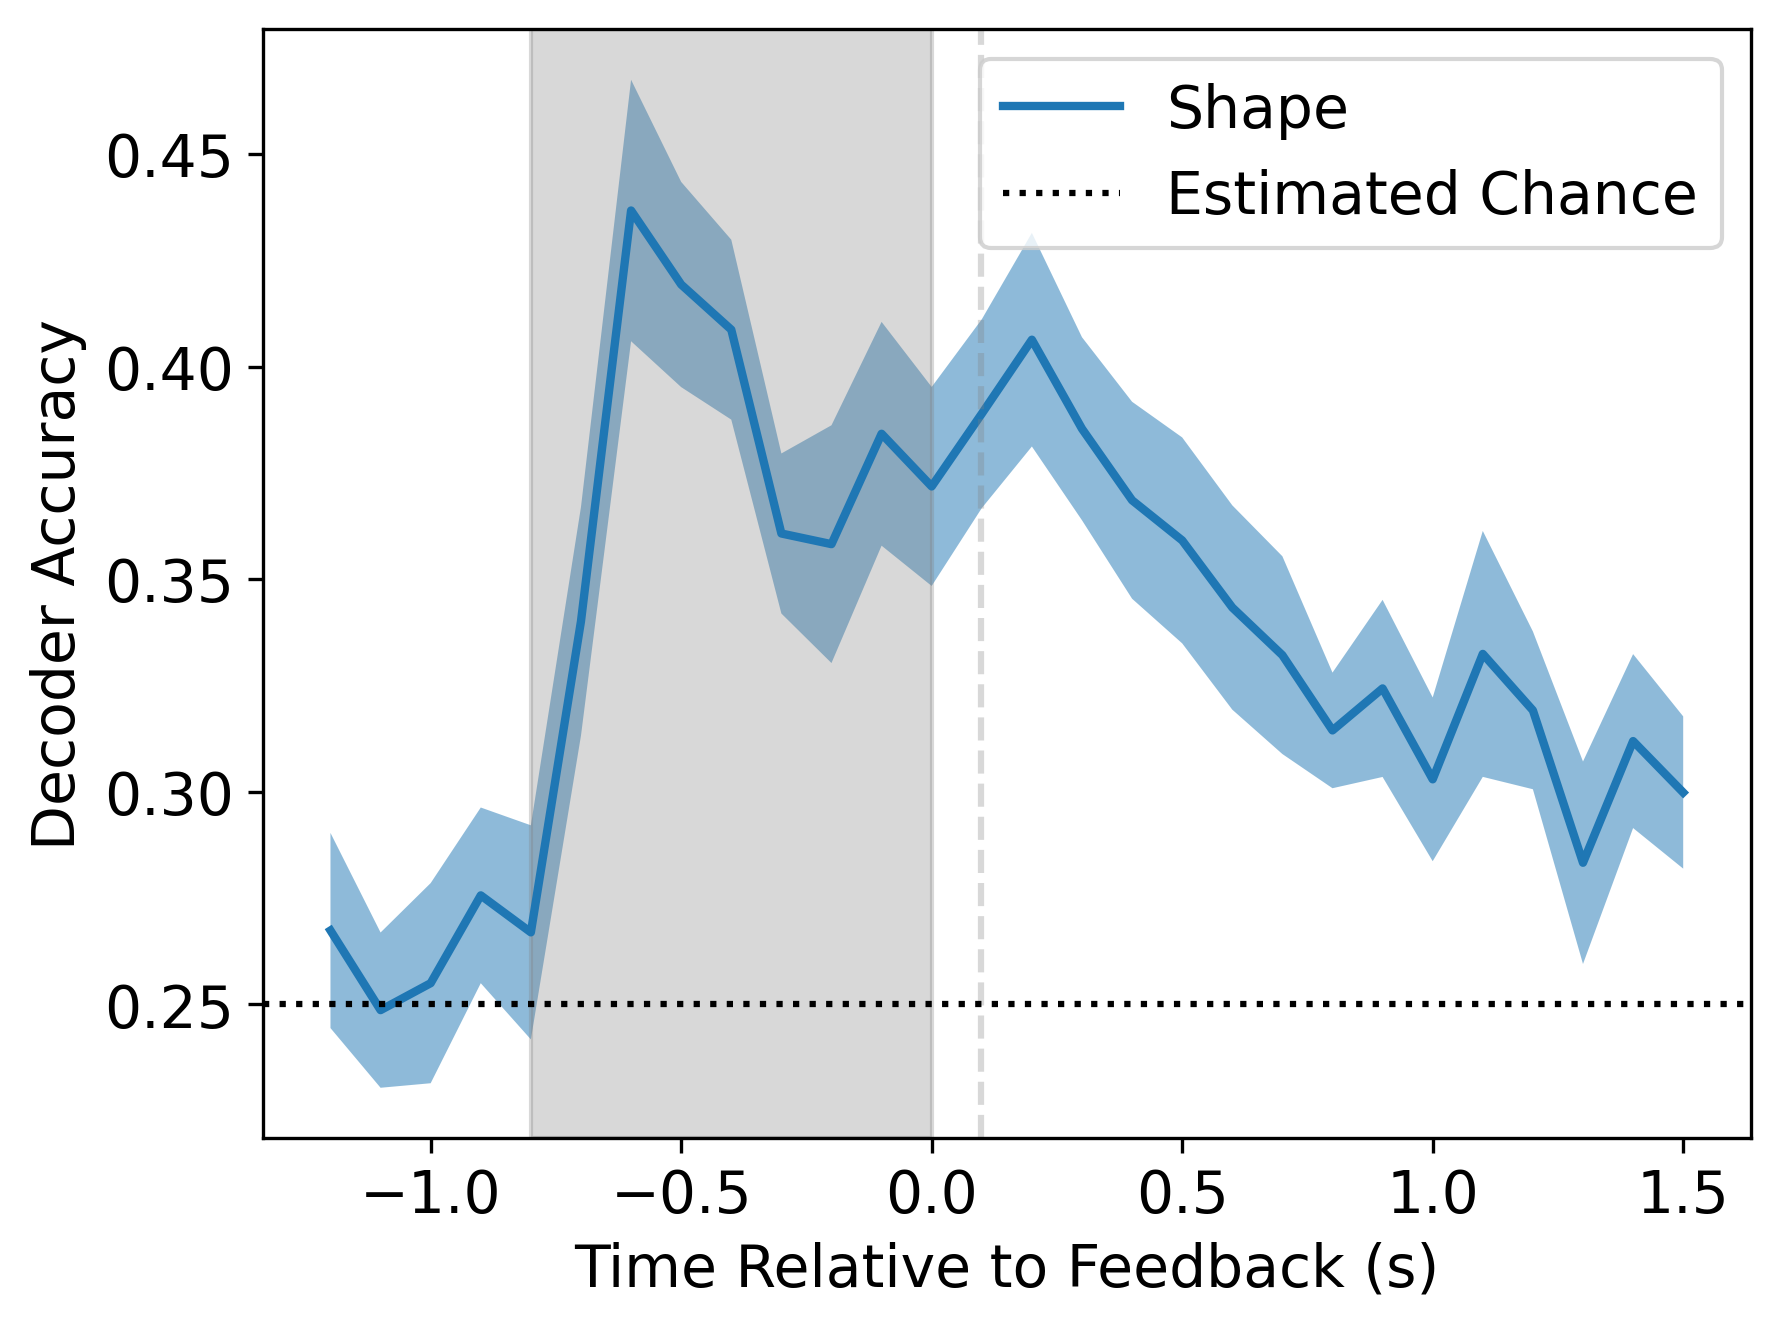

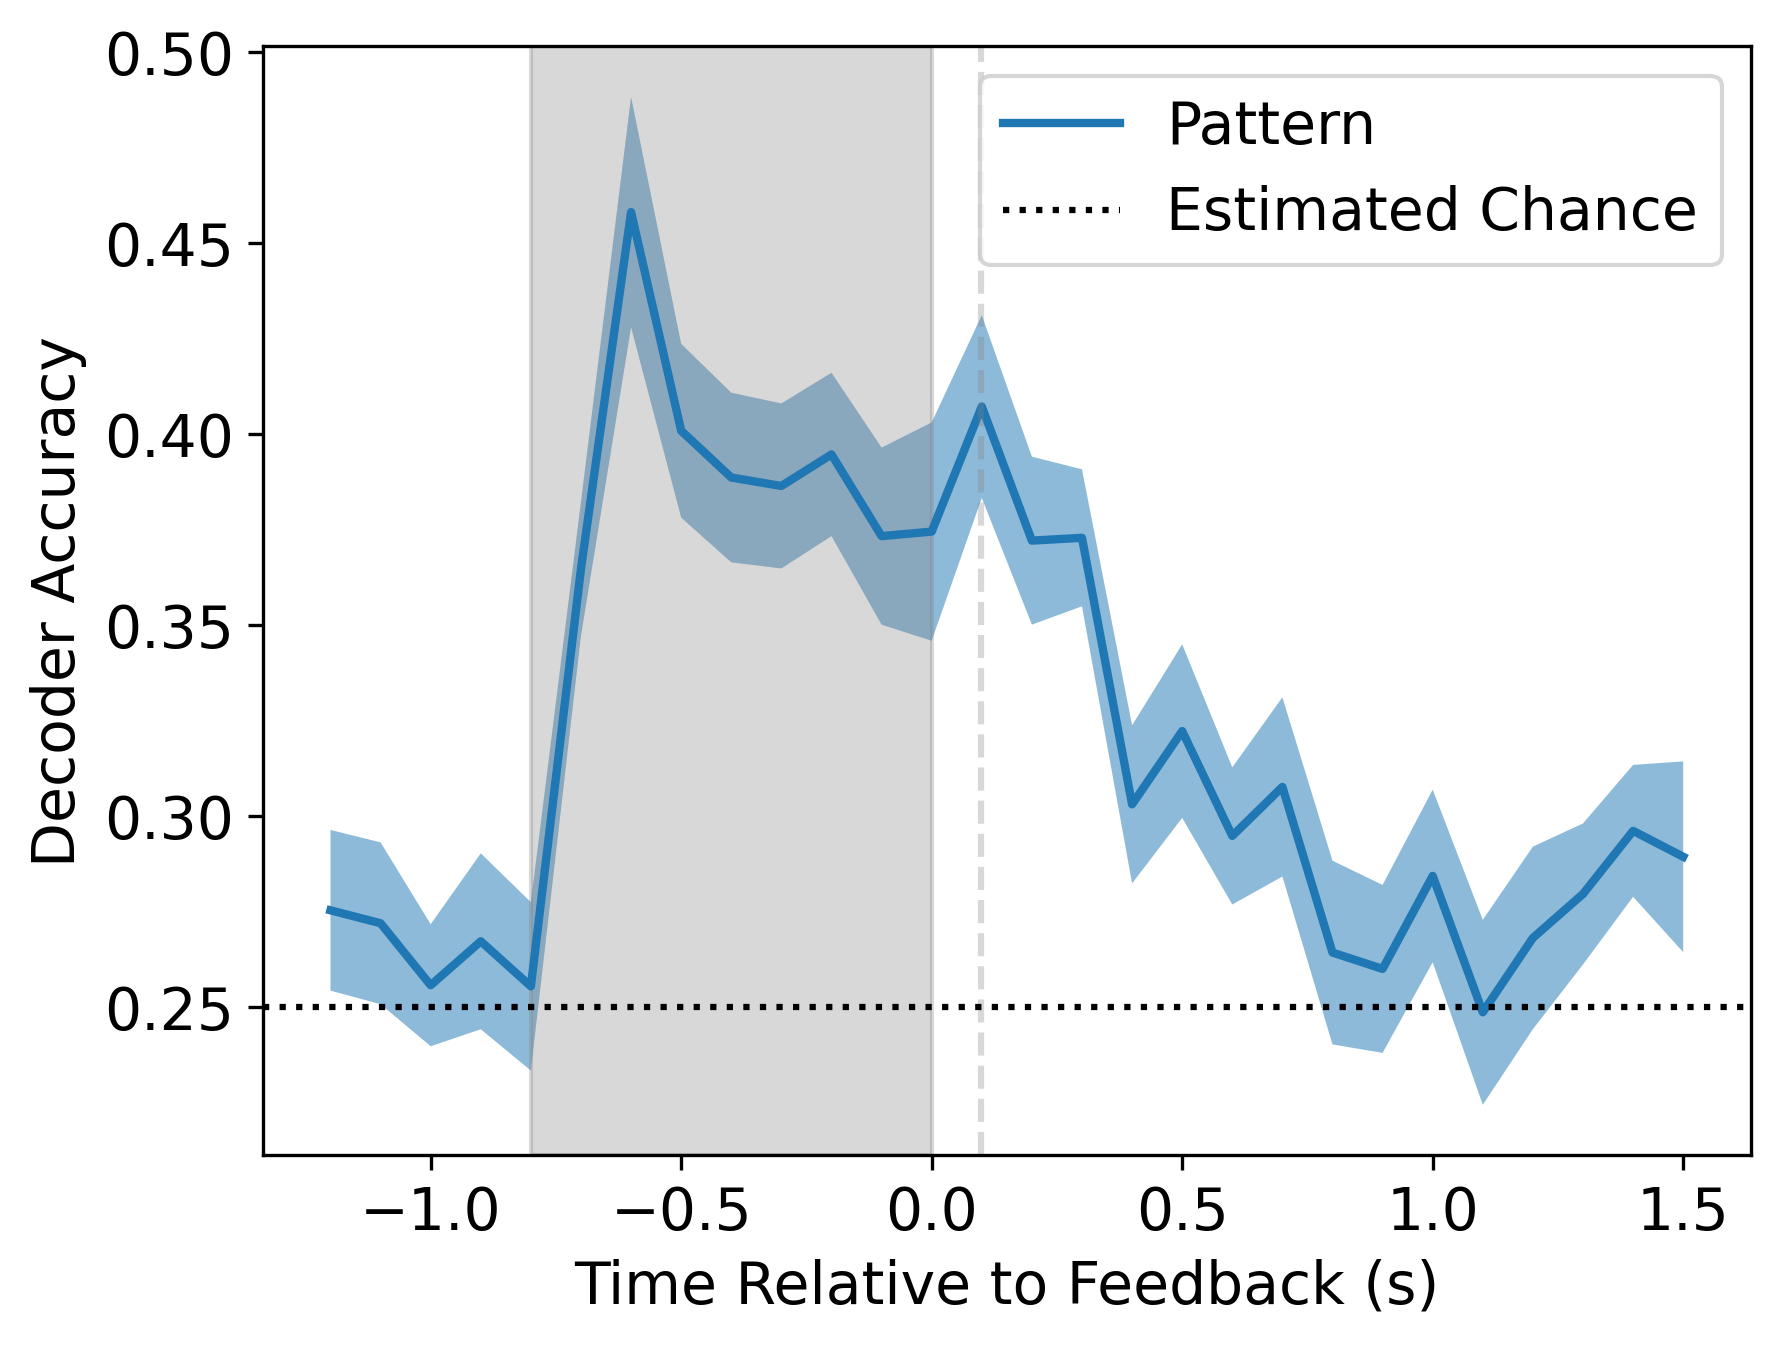

In [5]:
for feature_dim in feature_dims:
    _, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
        feature_dim, 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        1.3, 1.5, 0.1,
        ax,
        label=feature_dim,
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Replot original with KFold Block splitter

In [ ]:
for feature_dim in feature_dims:
    train_model(feature_dim, firing_rates, feature_selections, 
    1300, 1500, 100, feature_dim, "fb", 
    KFoldBlockSplitter(valid_beh, 10), "kfold_block_split")

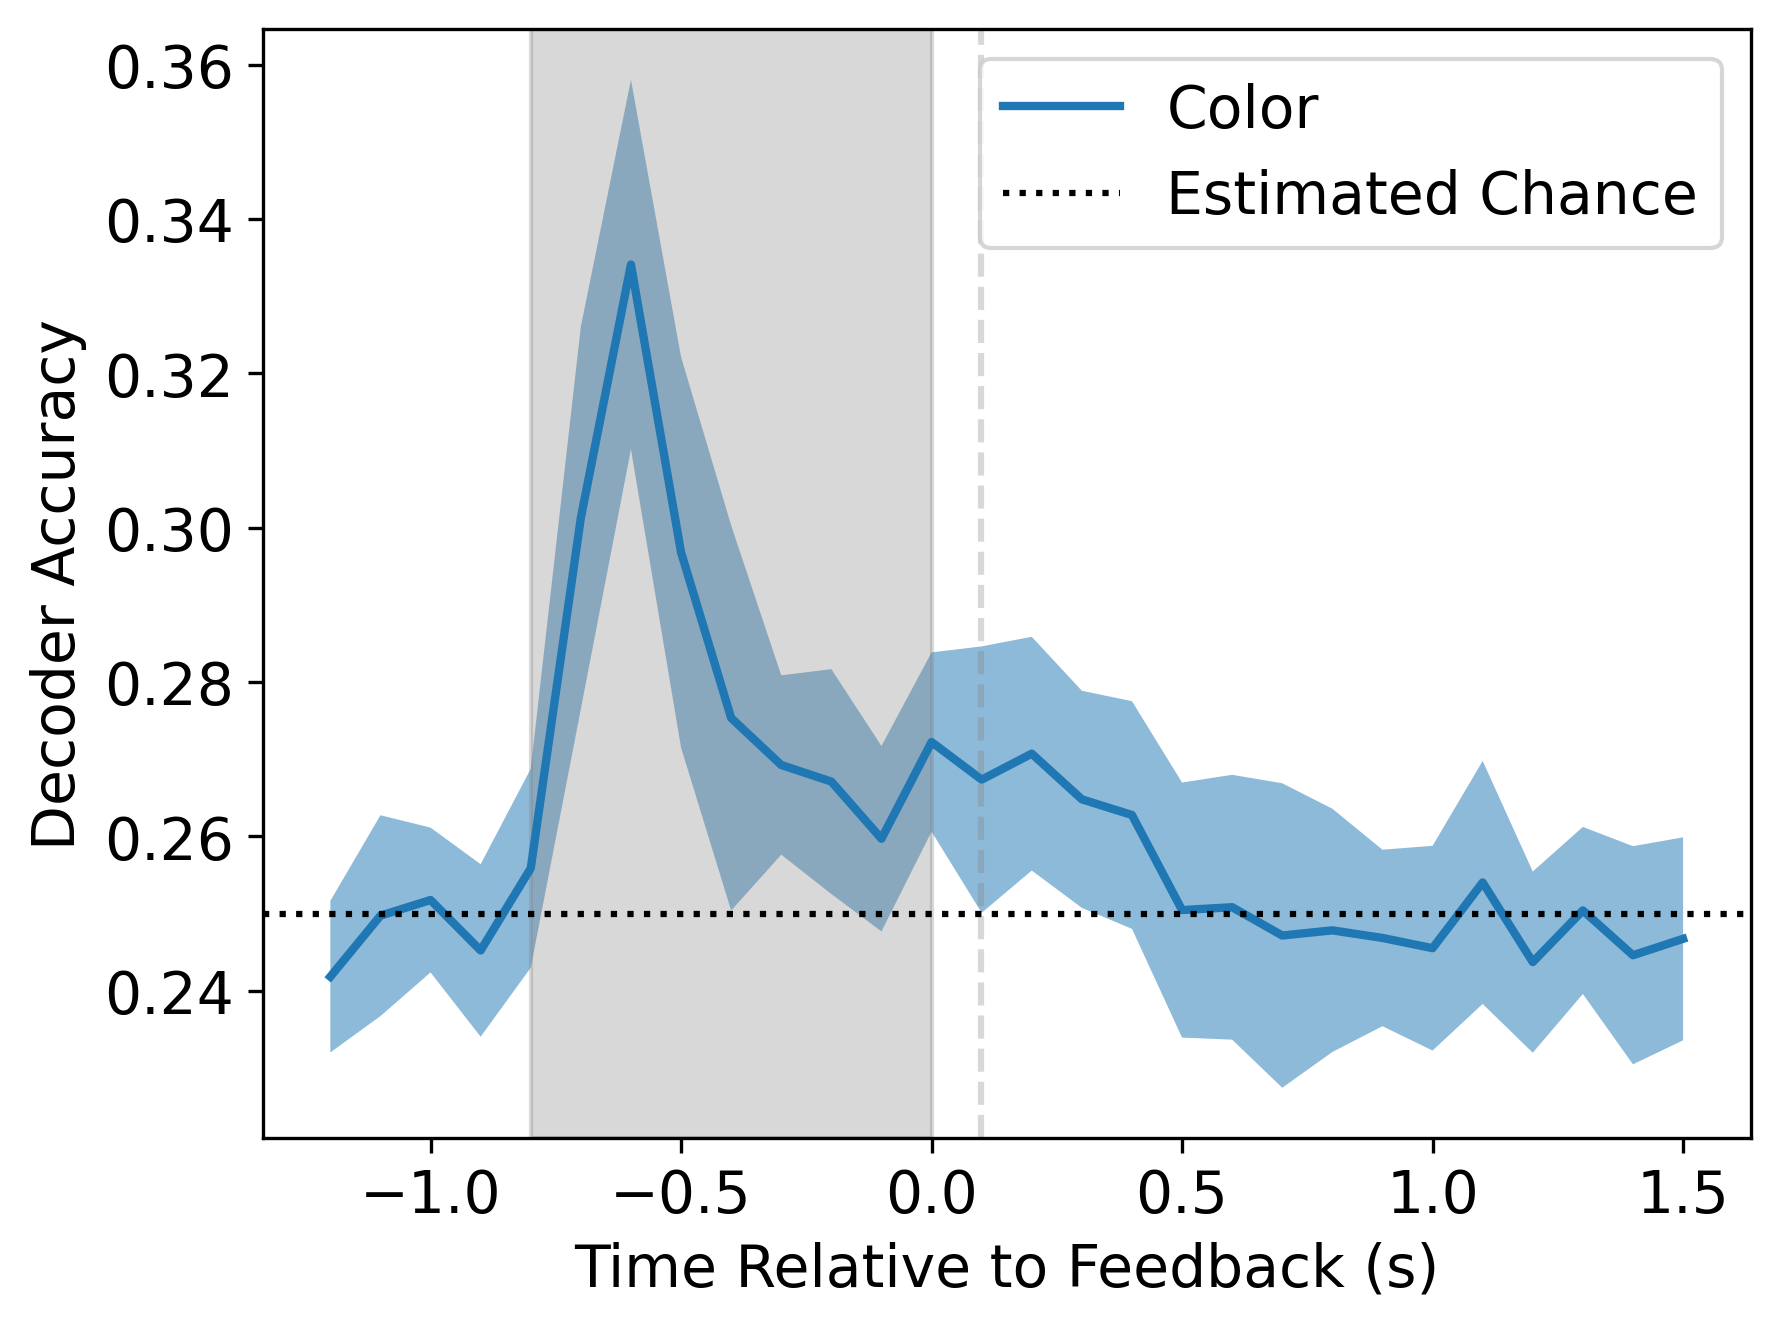

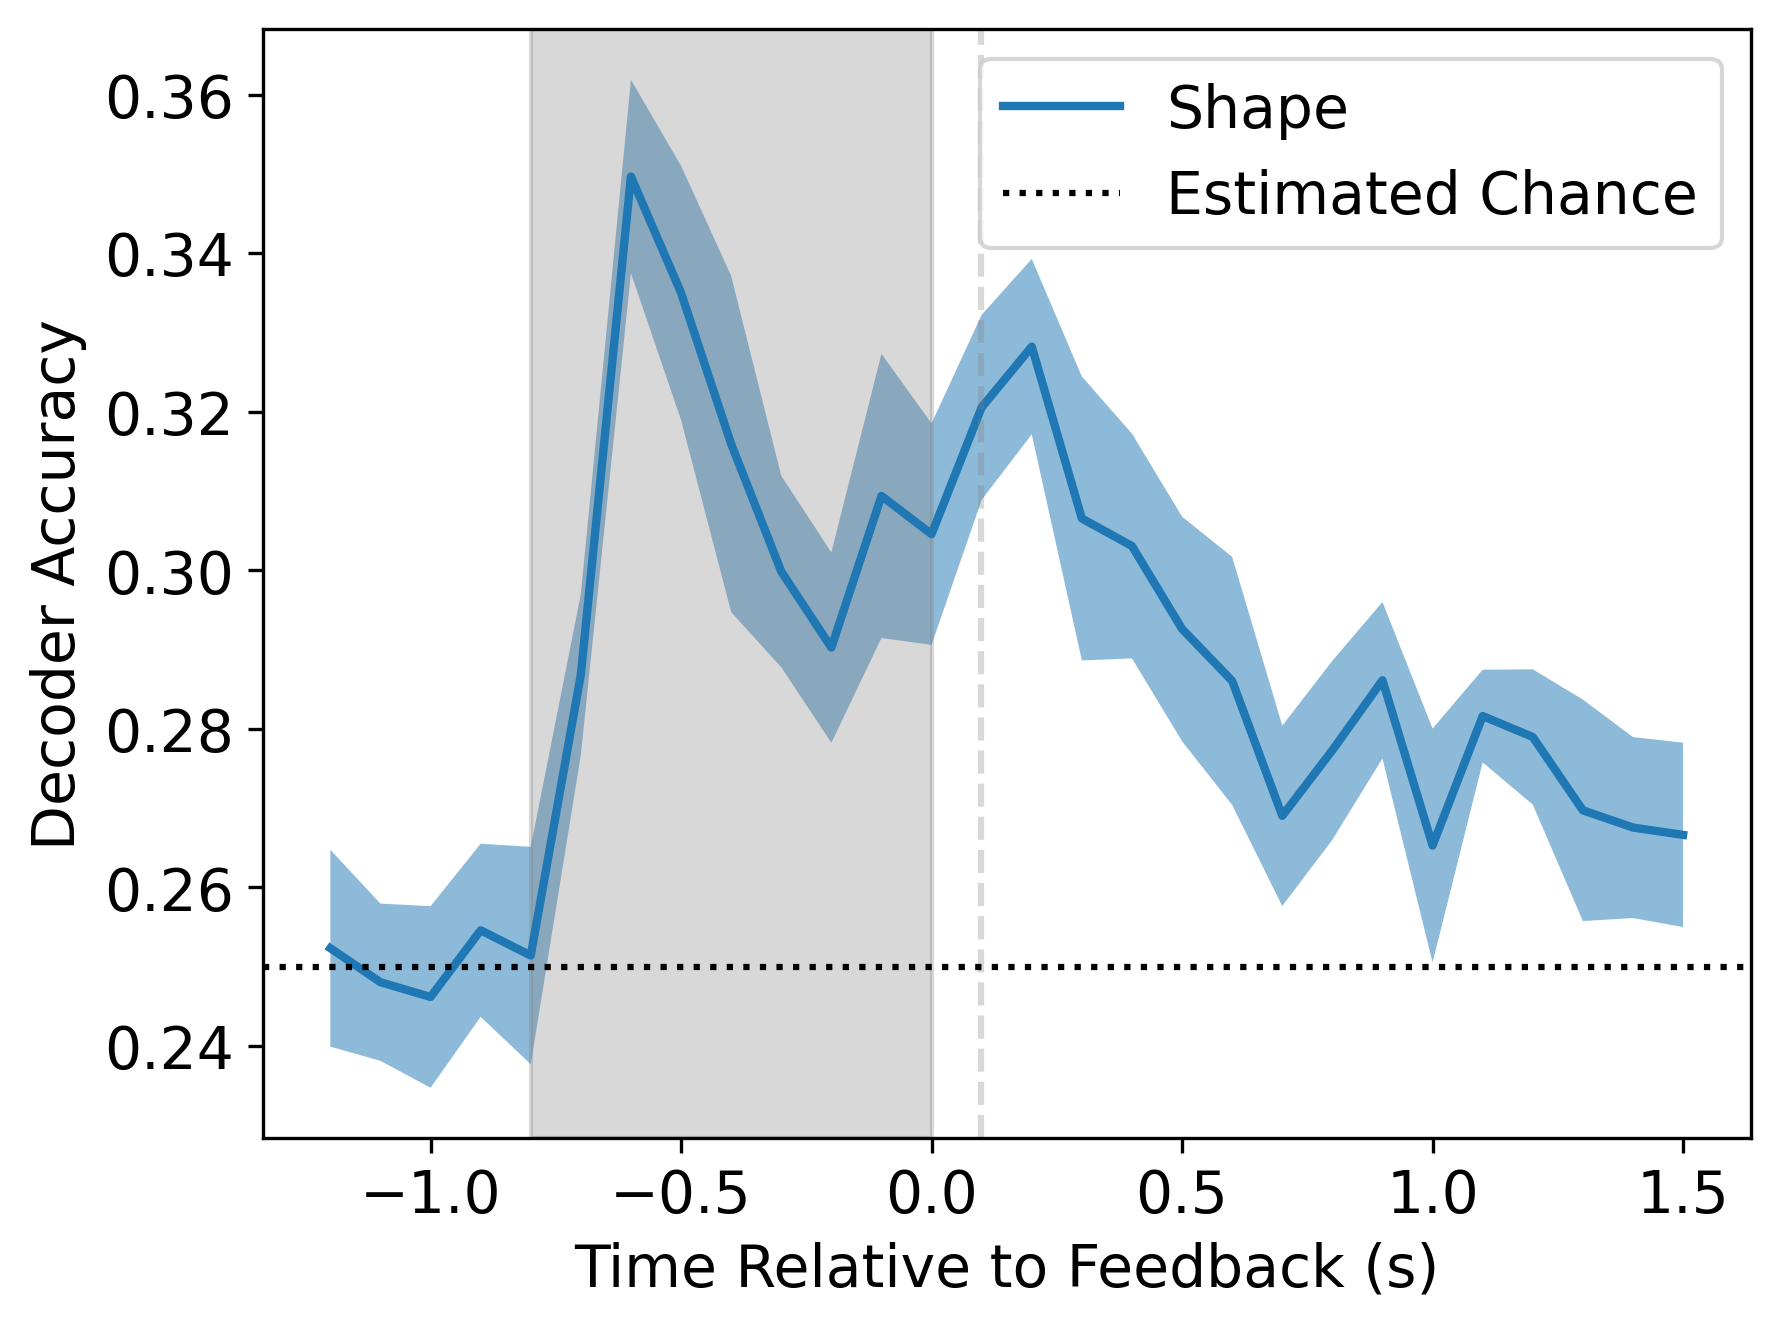

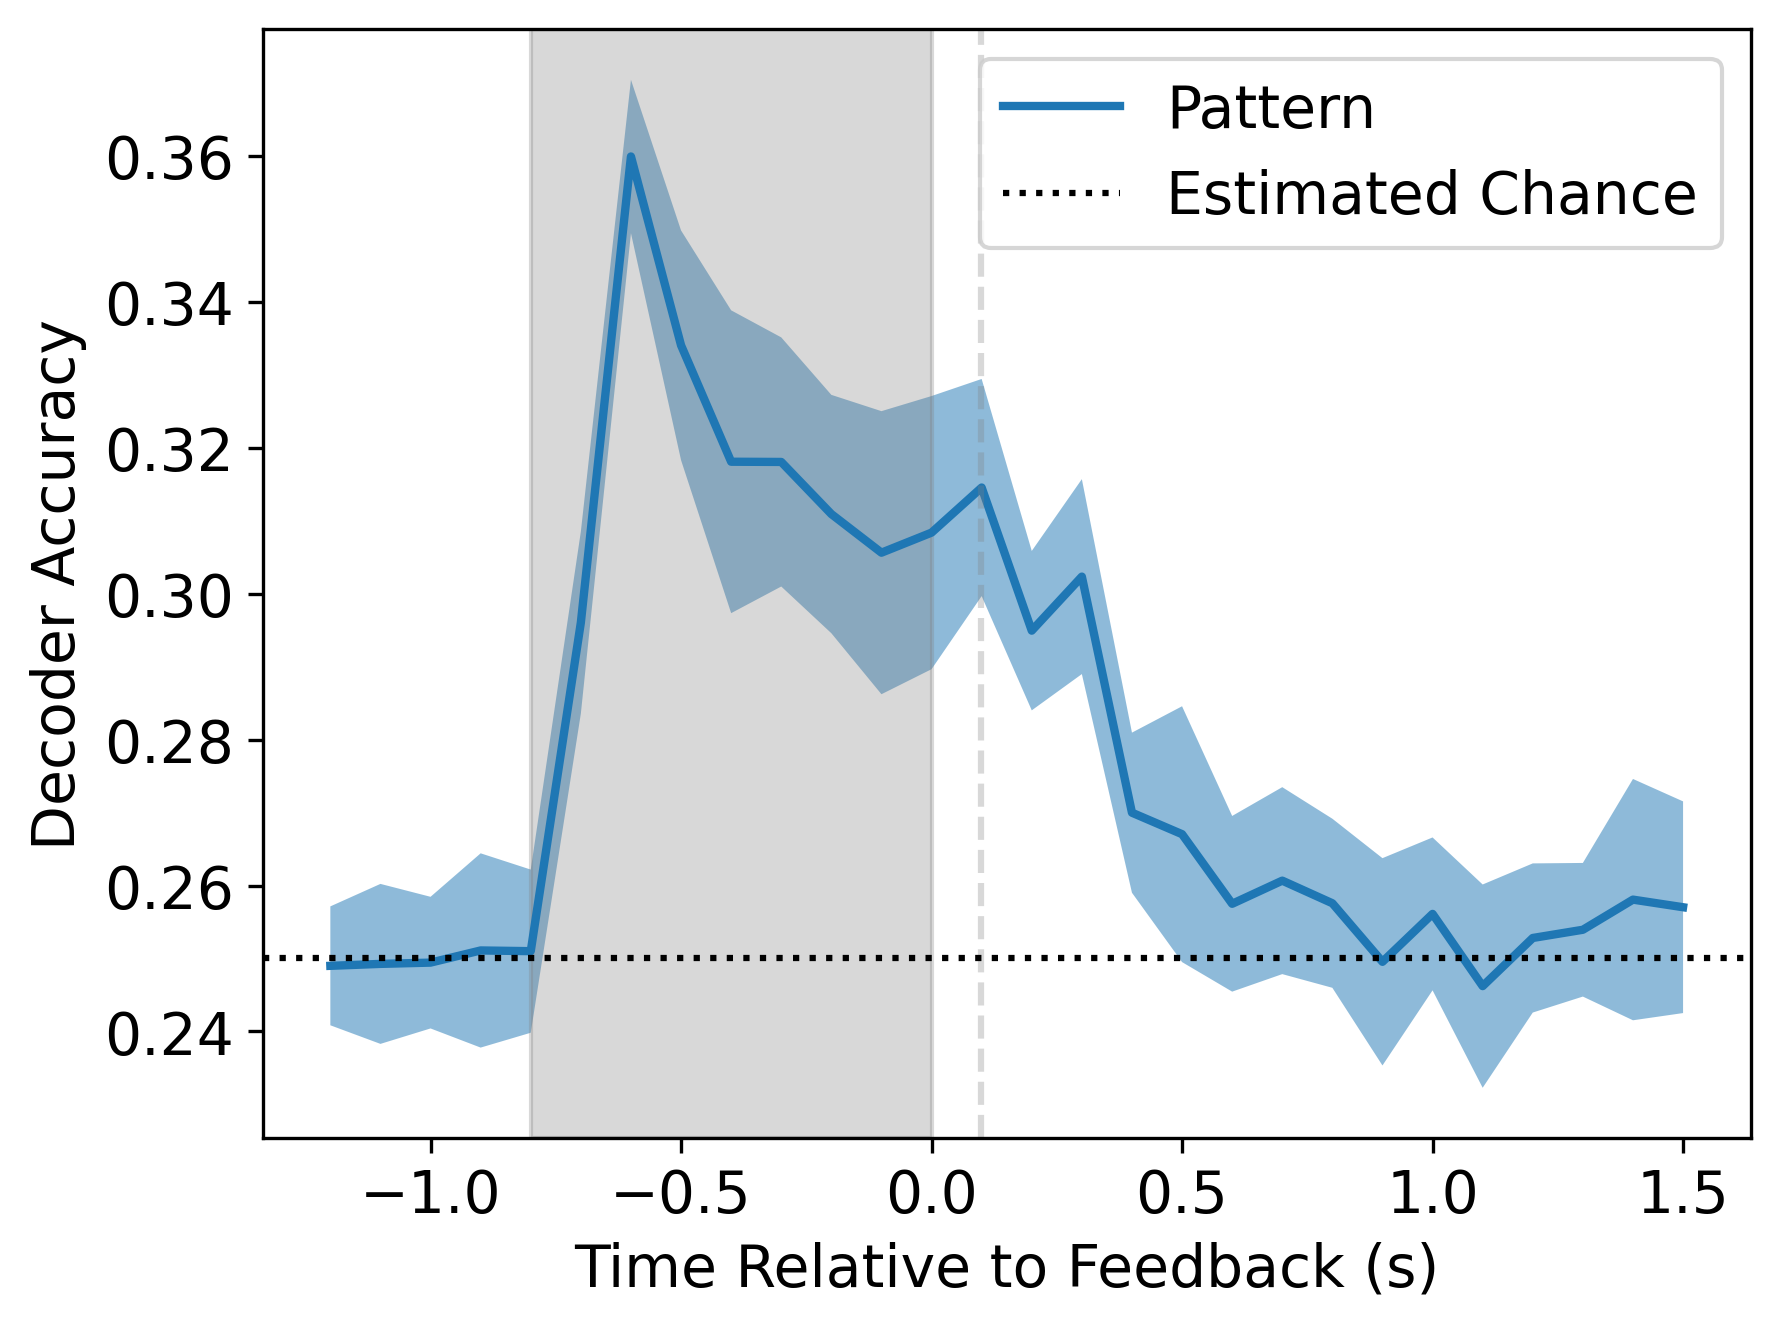

In [4]:
for feature_dim in feature_dims:
    _, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
        feature_dim, 
        f"{pre_interval}_fb_{post_interval}",
        "kfold_block_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        1.3, 1.5, 0.1,
        ax,
        label=feature_dim,
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Split feature decoding plots by correct/incorrect

In [ ]:
cor_trials = valid_beh[valid_beh.Response == "Correct"]
inc_trials = valid_beh[valid_beh.Response == "Incorrect"]

cor_frs = firing_rates[firing_rates.TrialNumber.isin(cor_trials.TrialNumber)]
inc_frs = firing_rates[firing_rates.TrialNumber.isin(inc_trials.TrialNumber)]

cor_fss = feature_selections[feature_selections.TrialNumber.isin(cor_trials.TrialNumber)]
inc_fss = feature_selections[feature_selections.TrialNumber.isin(inc_trials.TrialNumber)]

for feature_dim in feature_dims:
    train_model(feature_dim, cor_frs, cor_fss, 1300, 1500, 100, f"{feature_dim}_cor", "fb")
    train_model(feature_dim, inc_frs, inc_fss, 1300, 1500, 100, f"{feature_dim}_inc", "fb")

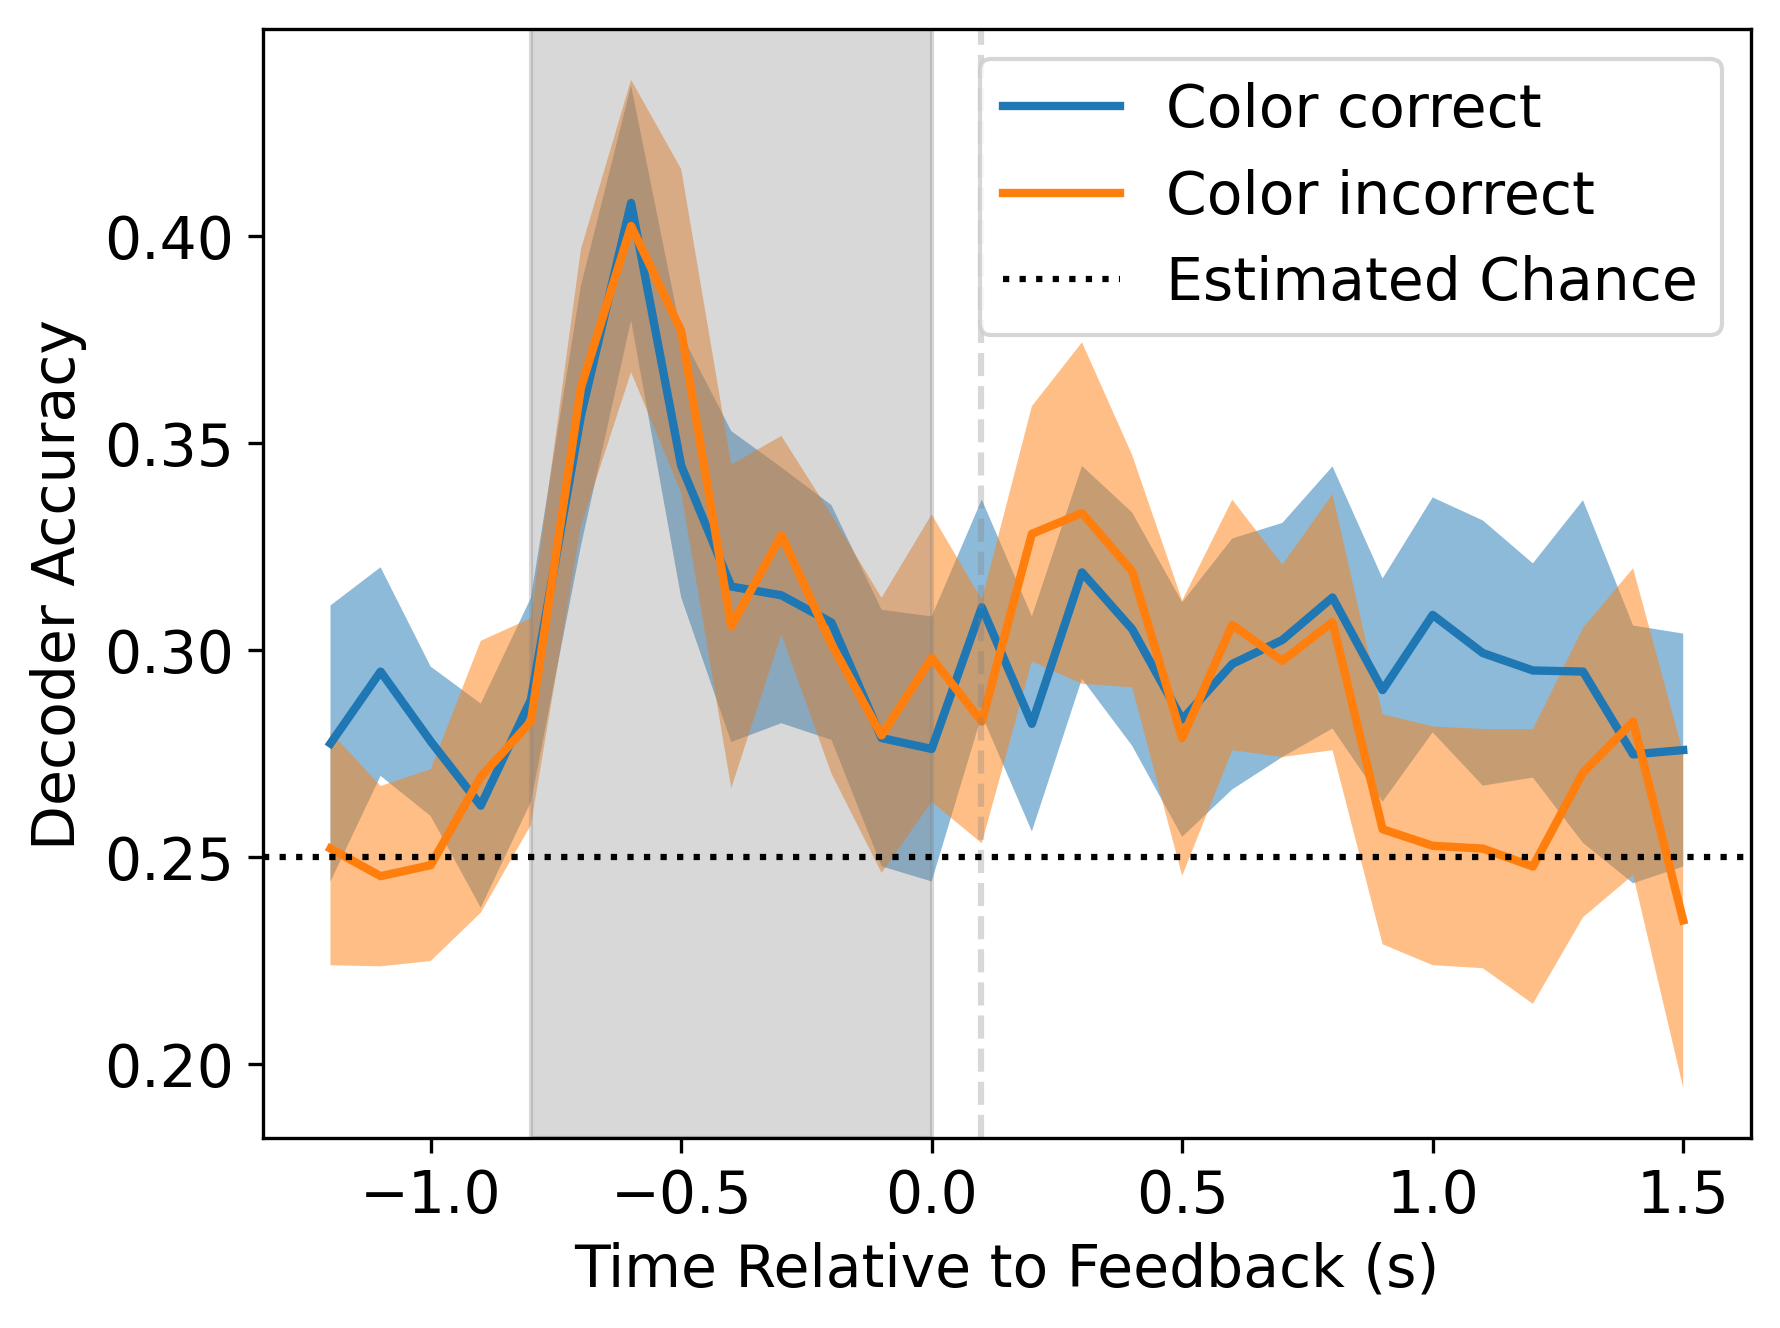

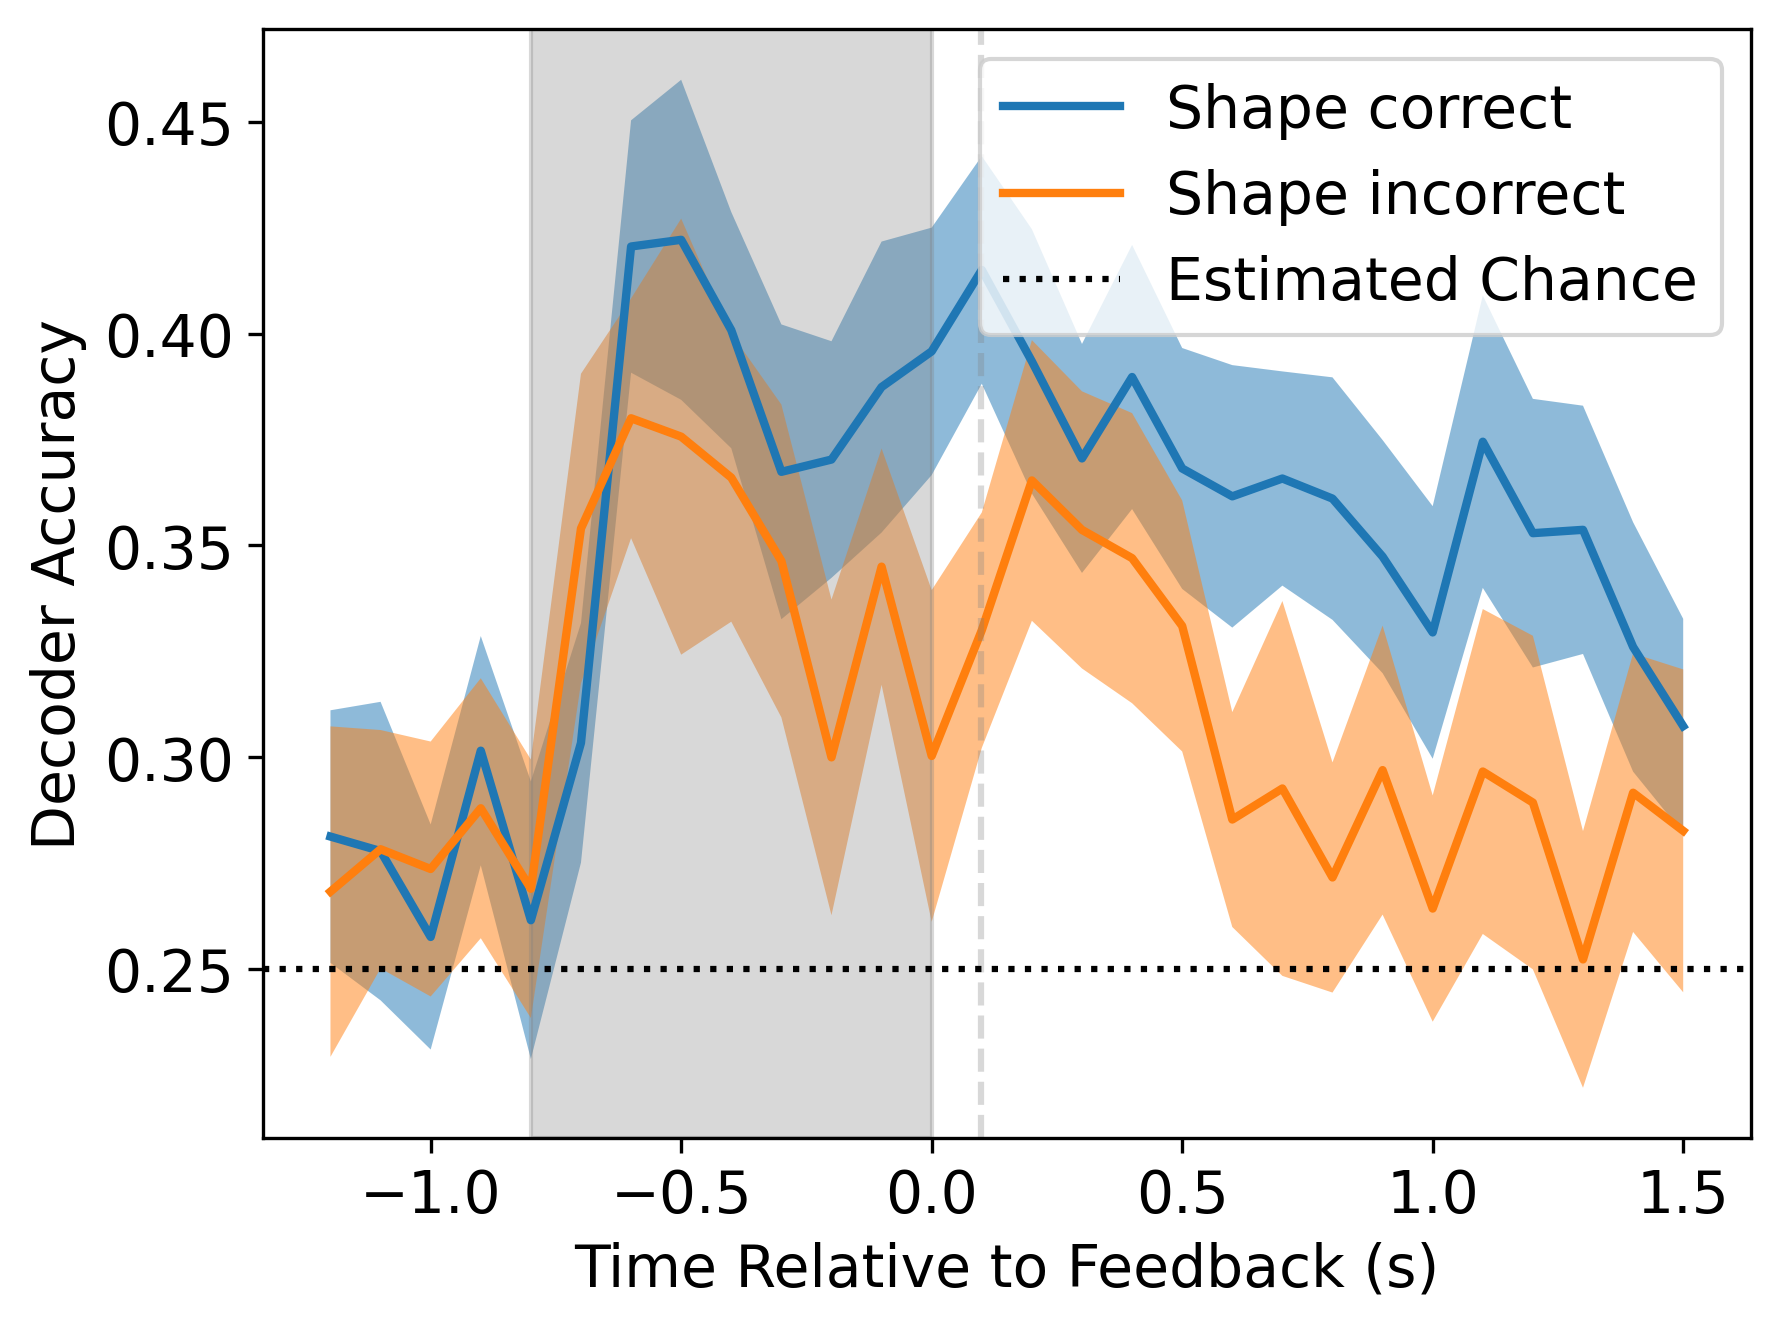

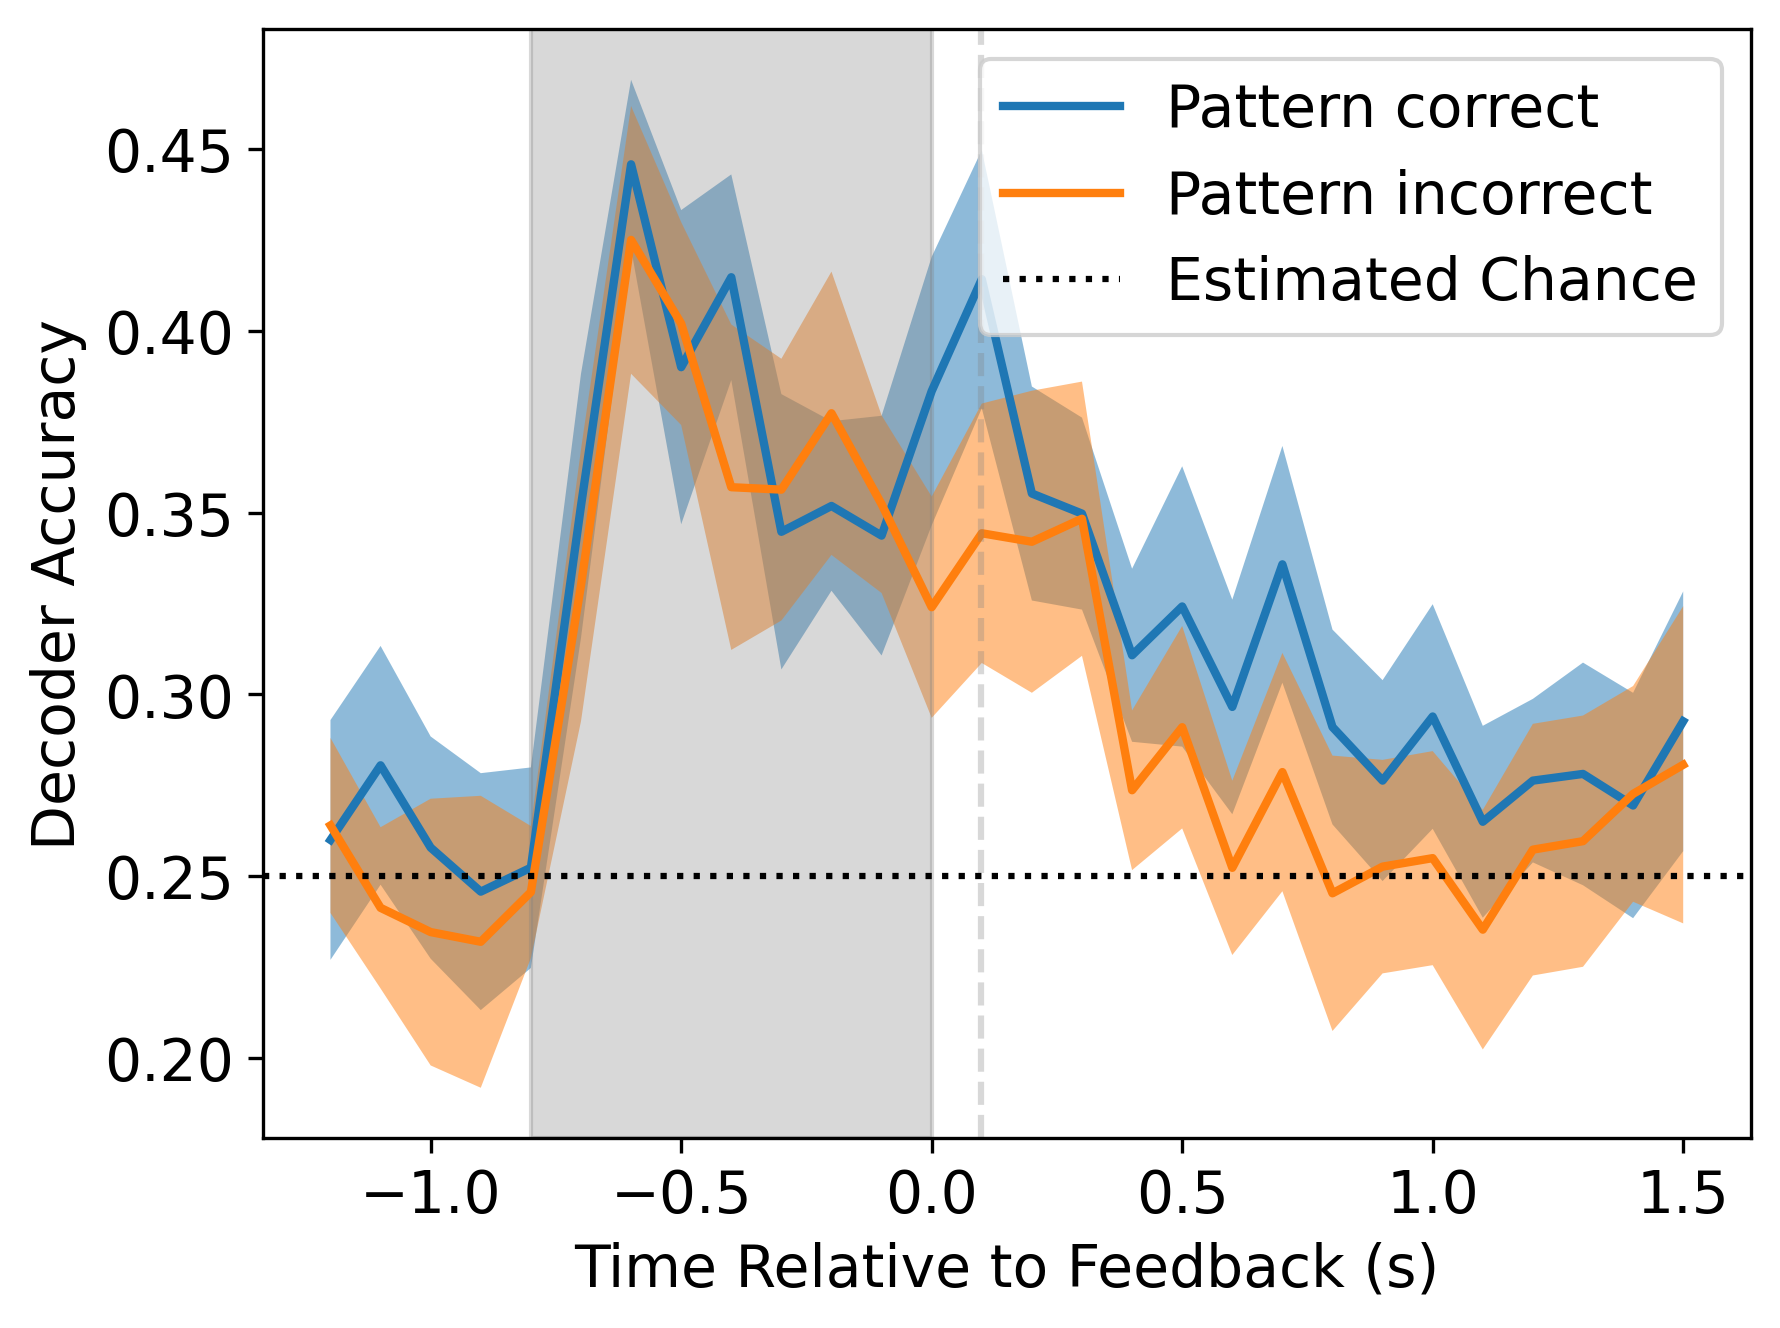

In [4]:
for feature_dim in feature_dims:
    _, cor_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_cor", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )
    _, inc_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_inc", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        cor_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim} correct",
        right_align=True, 
        # color='black'
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        inc_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim} incorrect",
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Corrects/Incorrects with Block Splitter

In [ ]:
cor_trials = valid_beh[valid_beh.Response == "Correct"]
inc_trials = valid_beh[valid_beh.Response == "Incorrect"]

cor_frs = firing_rates[firing_rates.TrialNumber.isin(cor_trials.TrialNumber)]
inc_frs = firing_rates[firing_rates.TrialNumber.isin(inc_trials.TrialNumber)]

cor_fss = feature_selections[feature_selections.TrialNumber.isin(cor_trials.TrialNumber)]
inc_fss = feature_selections[feature_selections.TrialNumber.isin(inc_trials.TrialNumber)]

for feature_dim in feature_dims:
    train_model(feature_dim, cor_frs, cor_fss, 1300, 1500, 100, f"{feature_dim}_cor", "fb",
    KFoldBlockSplitter(cor_trials, 10), "kfold_block_split")
    train_model(feature_dim, inc_frs, inc_fss, 1300, 1500, 100, f"{feature_dim}_inc", "fb",
    KFoldBlockSplitter(inc_trials, 10), "kfold_block_split")


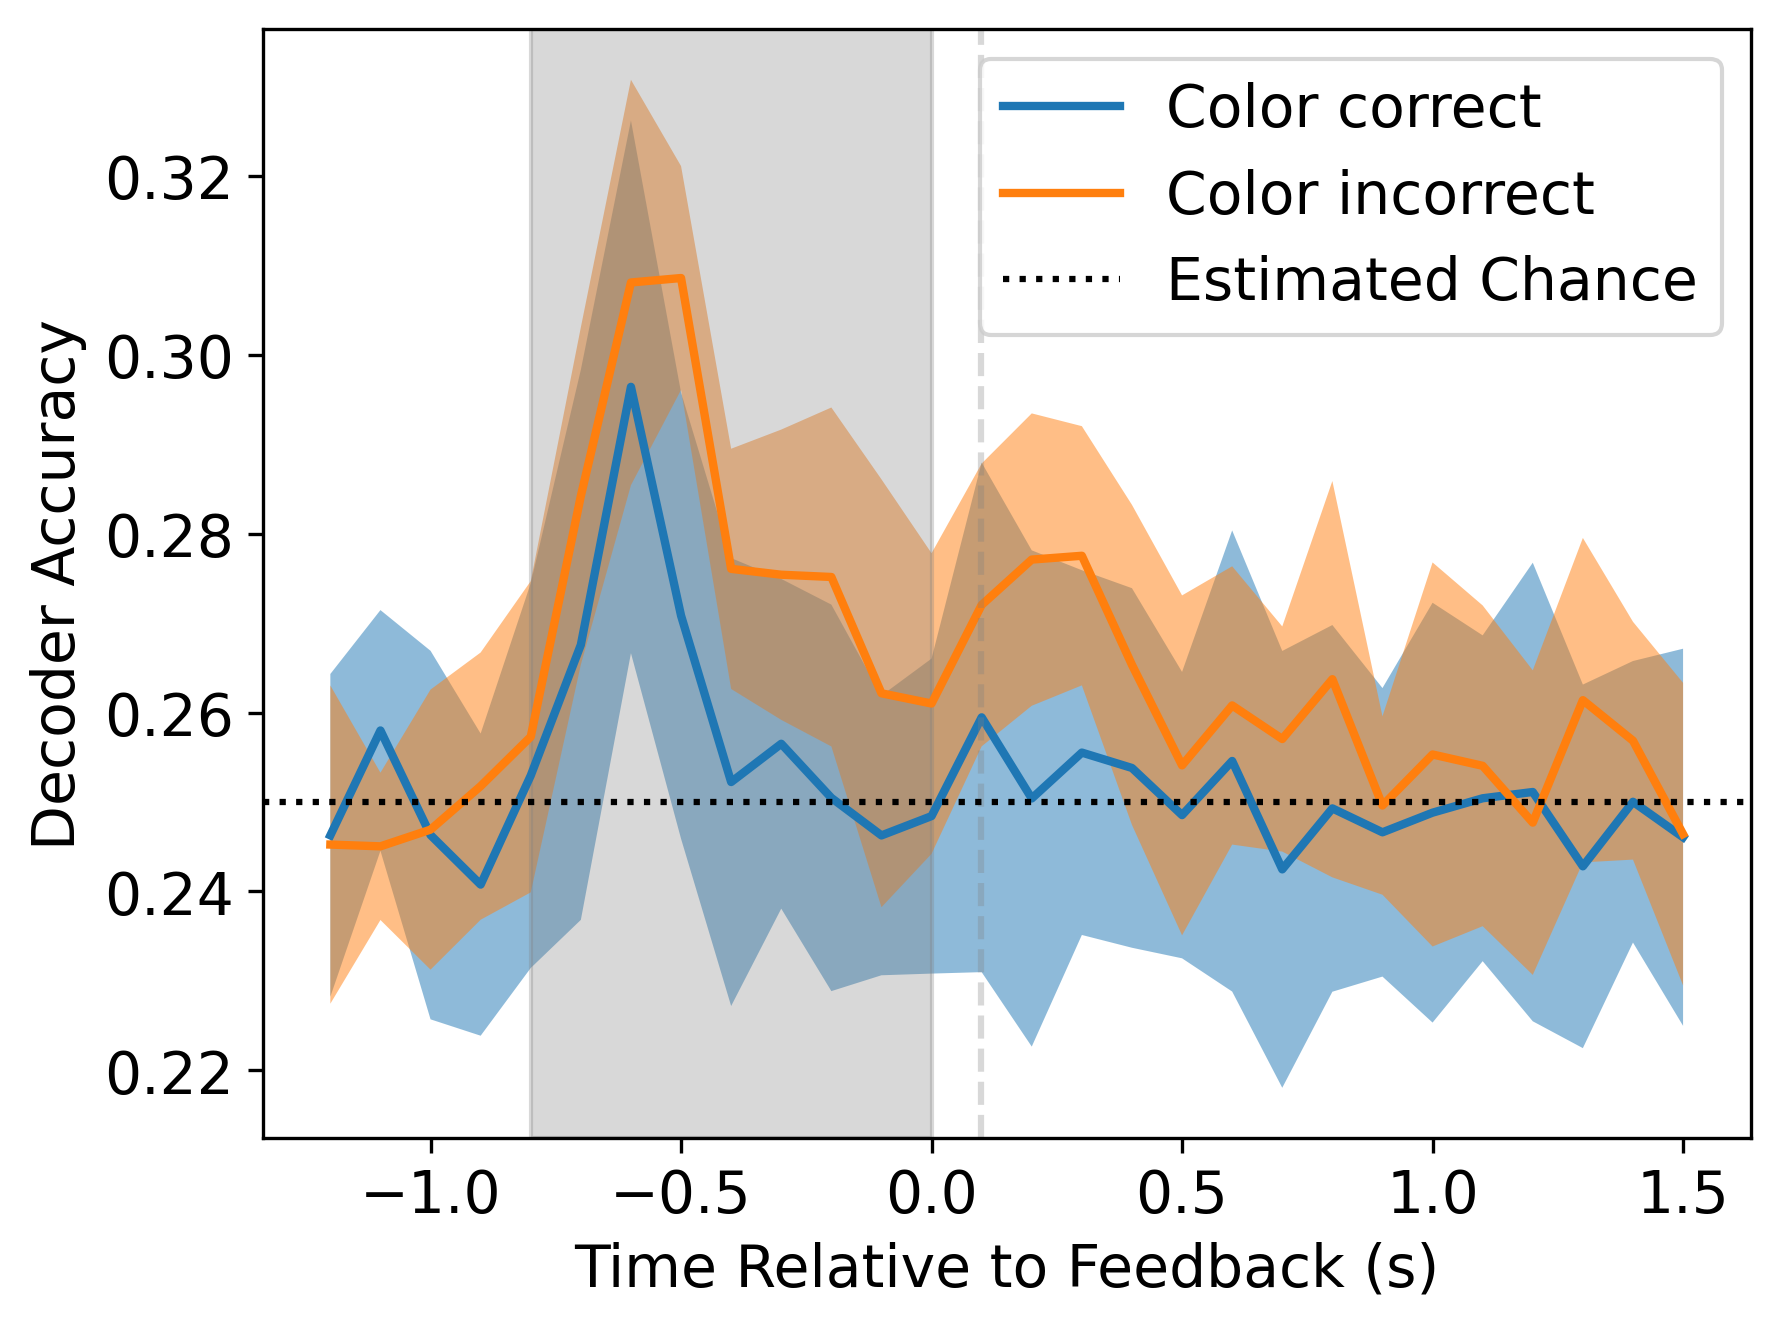

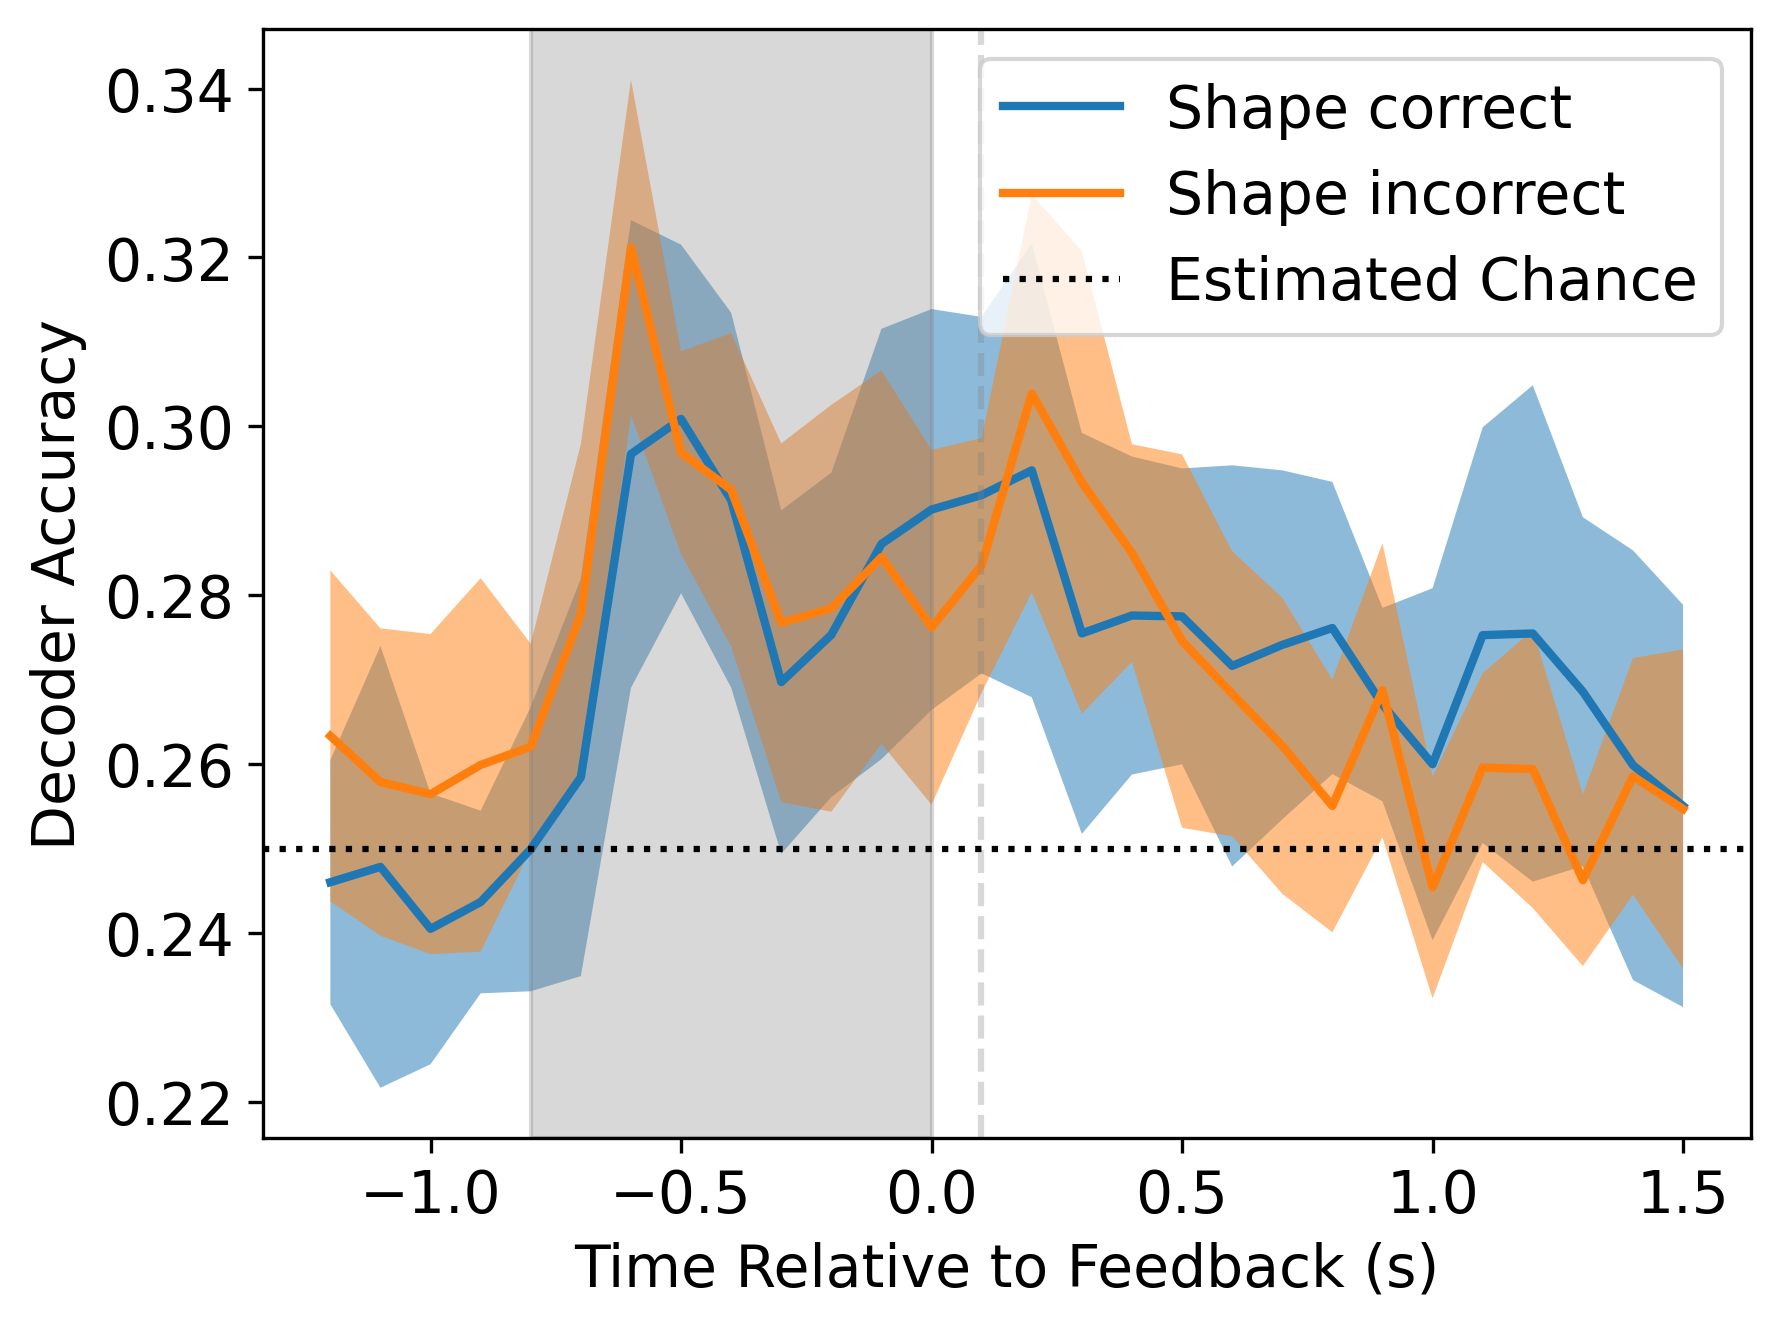

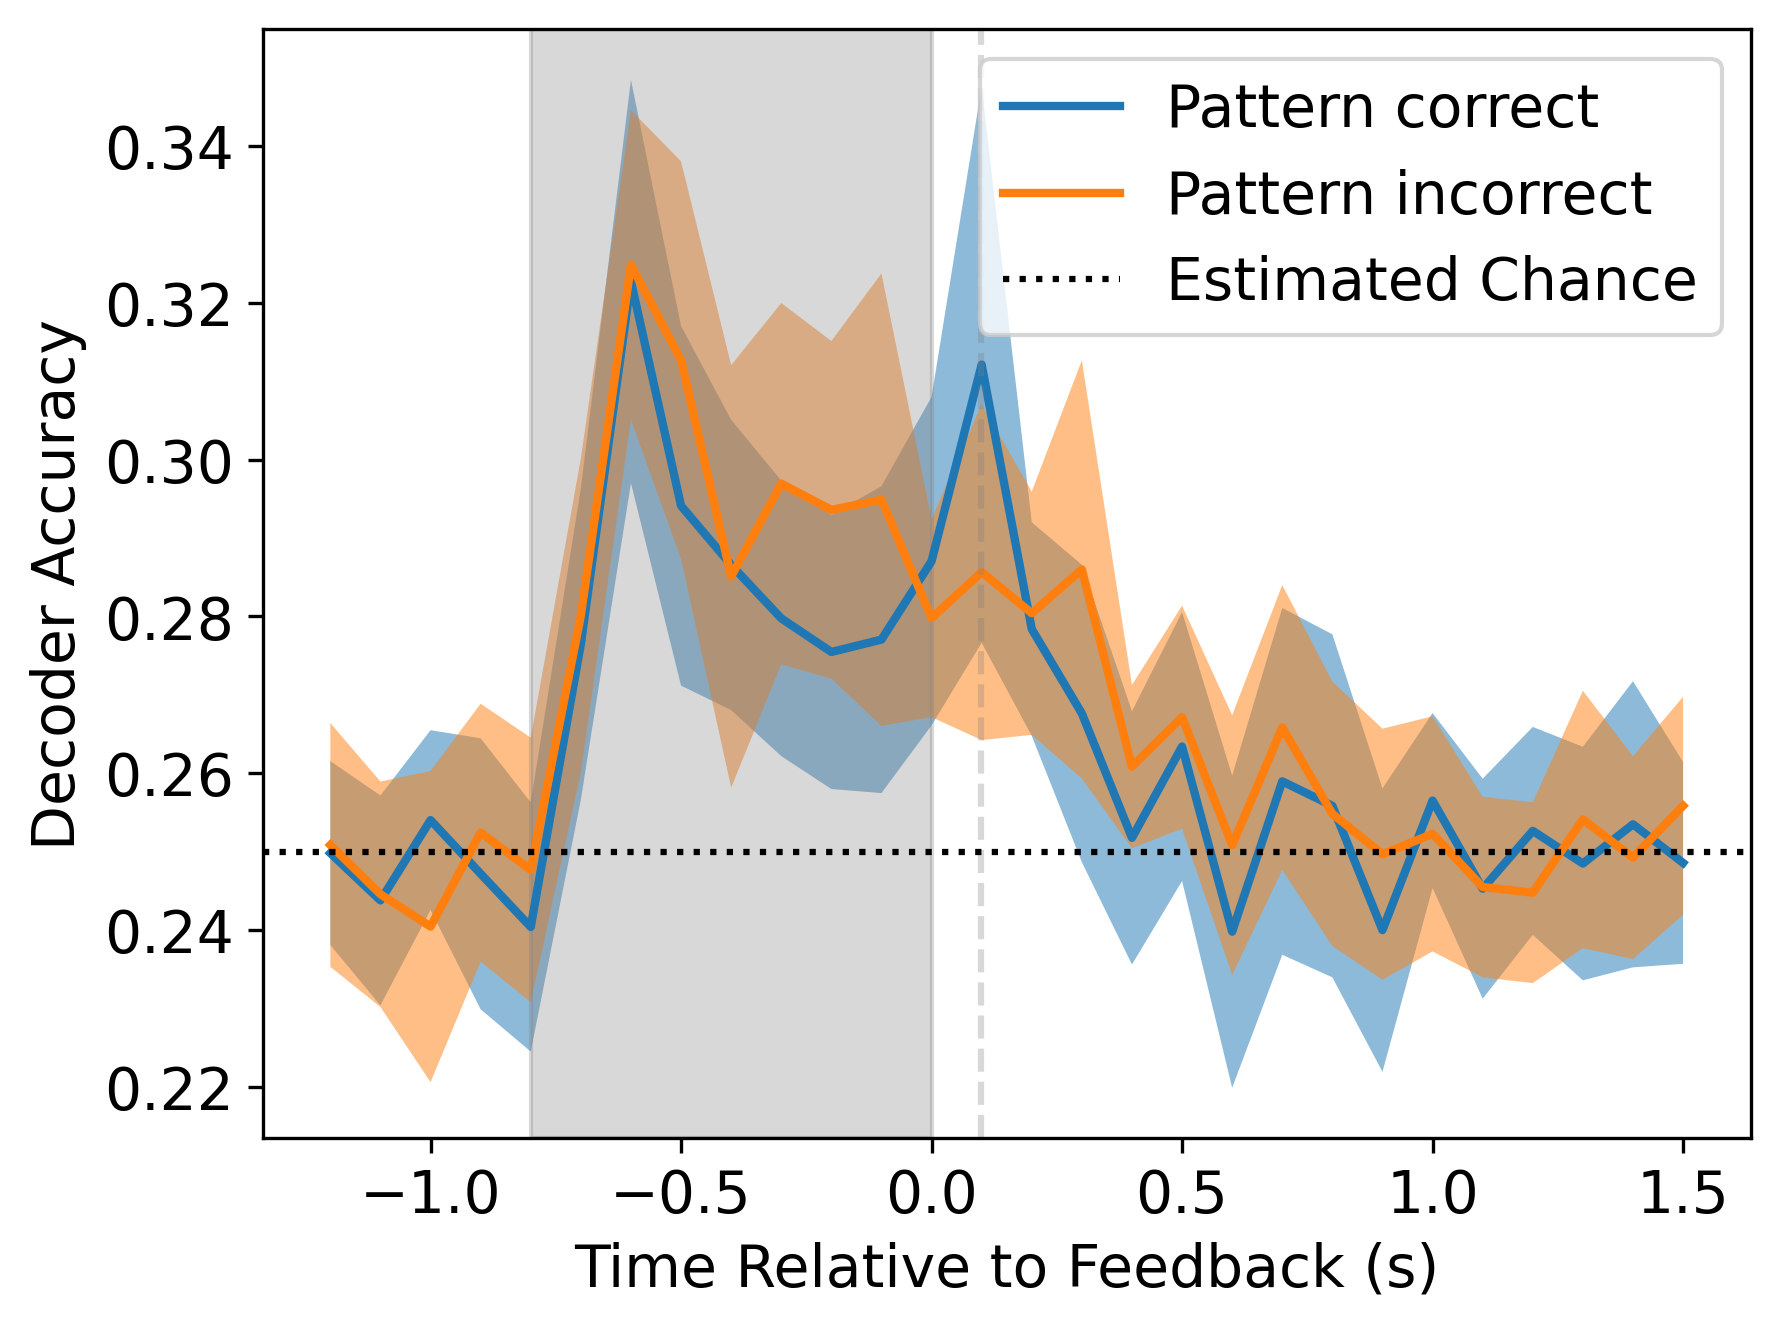

In [6]:
for feature_dim in feature_dims:
    _, cor_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_cor", 
        f"{pre_interval}_fb_{post_interval}",
        "kfold_block_split",
    )
    _, inc_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_inc", 
        f"{pre_interval}_fb_{post_interval}",
        "kfold_block_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        cor_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim} correct",
        right_align=True, 
        # color='black'
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        inc_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim} incorrect",
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Split corrects by whether feature chosen on next trial

In [7]:
fs_w_next = feature_selections.copy()
fs_w_next["NextColor"] = fs_w_next.Color.shift(-1)
fs_w_next["NextShape"] = fs_w_next.Shape.shift(-1)
fs_w_next["NextPattern"] = fs_w_next.Pattern.shift(-1)

In [8]:
# find trials where next trial is also valid
next_valid_trials = valid_beh[valid_beh.TrialNumber.isin(valid_beh.TrialNumber + 1)]
prev_valid_trials = valid_beh[valid_beh.TrialNumber.isin(next_valid_trials.TrialNumber - 1)]
prev_valid_trials_cor = prev_valid_trials[prev_valid_trials.Response == "Correct"]

sub_fs_w_next = fs_w_next[fs_w_next.TrialNumber.isin(prev_valid_trials_cor.TrialNumber)]

In [ ]:
for feature_dim in feature_dims:
    chose_next_fs = sub_fs_w_next[sub_fs_w_next[feature_dim] == sub_fs_w_next[f"Next{feature_dim}"]]
    not_chose_next_fs = sub_fs_w_next[sub_fs_w_next[feature_dim] != sub_fs_w_next[f"Next{feature_dim}"]]

    chose_next_frs = firing_rates[firing_rates.TrialNumber.isin(chose_next_fs.TrialNumber)]
    not_chose_next_frs = firing_rates[firing_rates.TrialNumber.isin(not_chose_next_fs.TrialNumber)]

    train_model(feature_dim, chose_next_frs, chose_next_fs, 1300, 1500, 100, f"{feature_dim}_chose_next", "fb")
    train_model(feature_dim, not_chose_next_frs, not_chose_next_fs, 1300, 1500, 100, f"{feature_dim}_not_chose_next", "fb")   

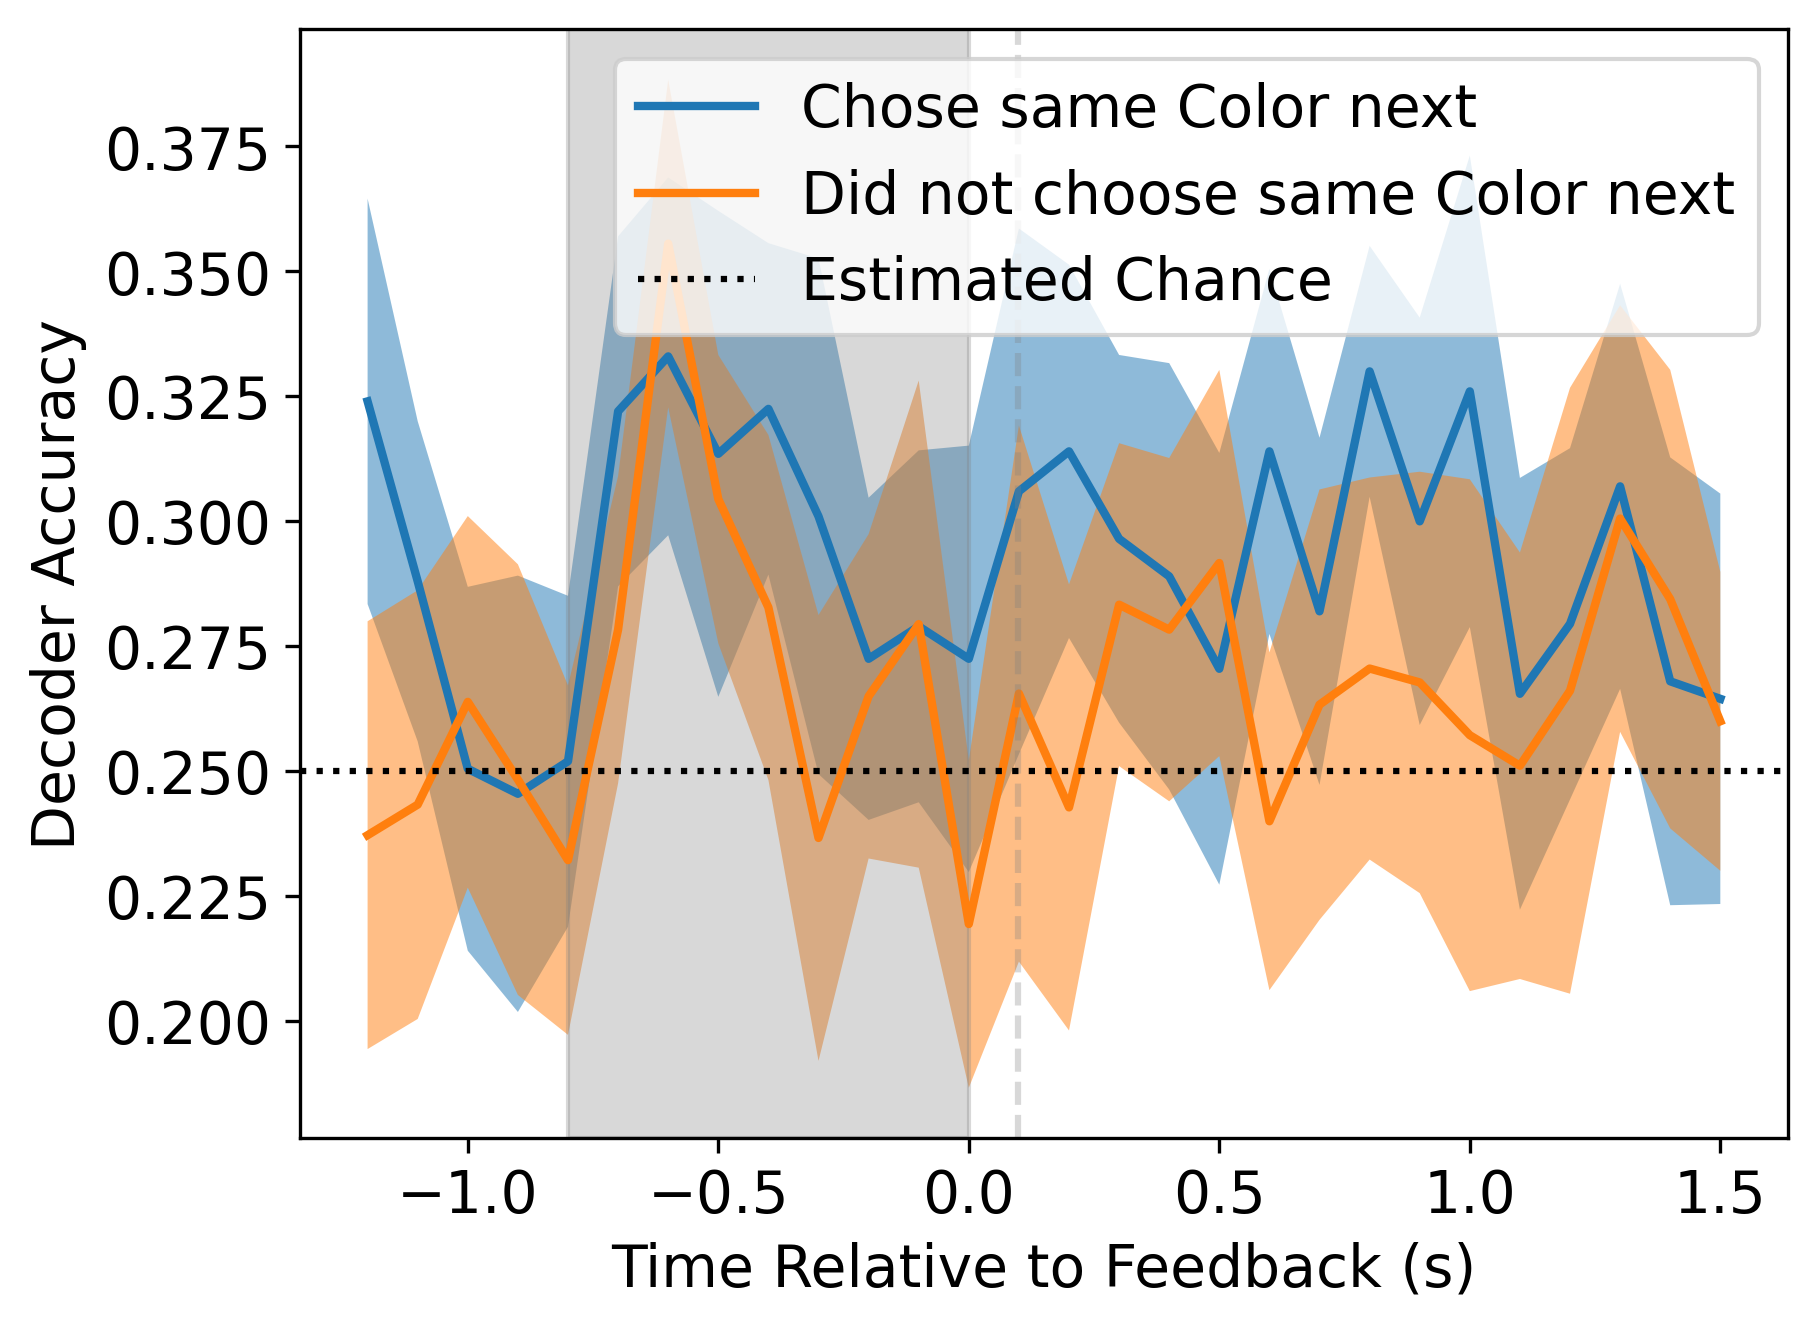

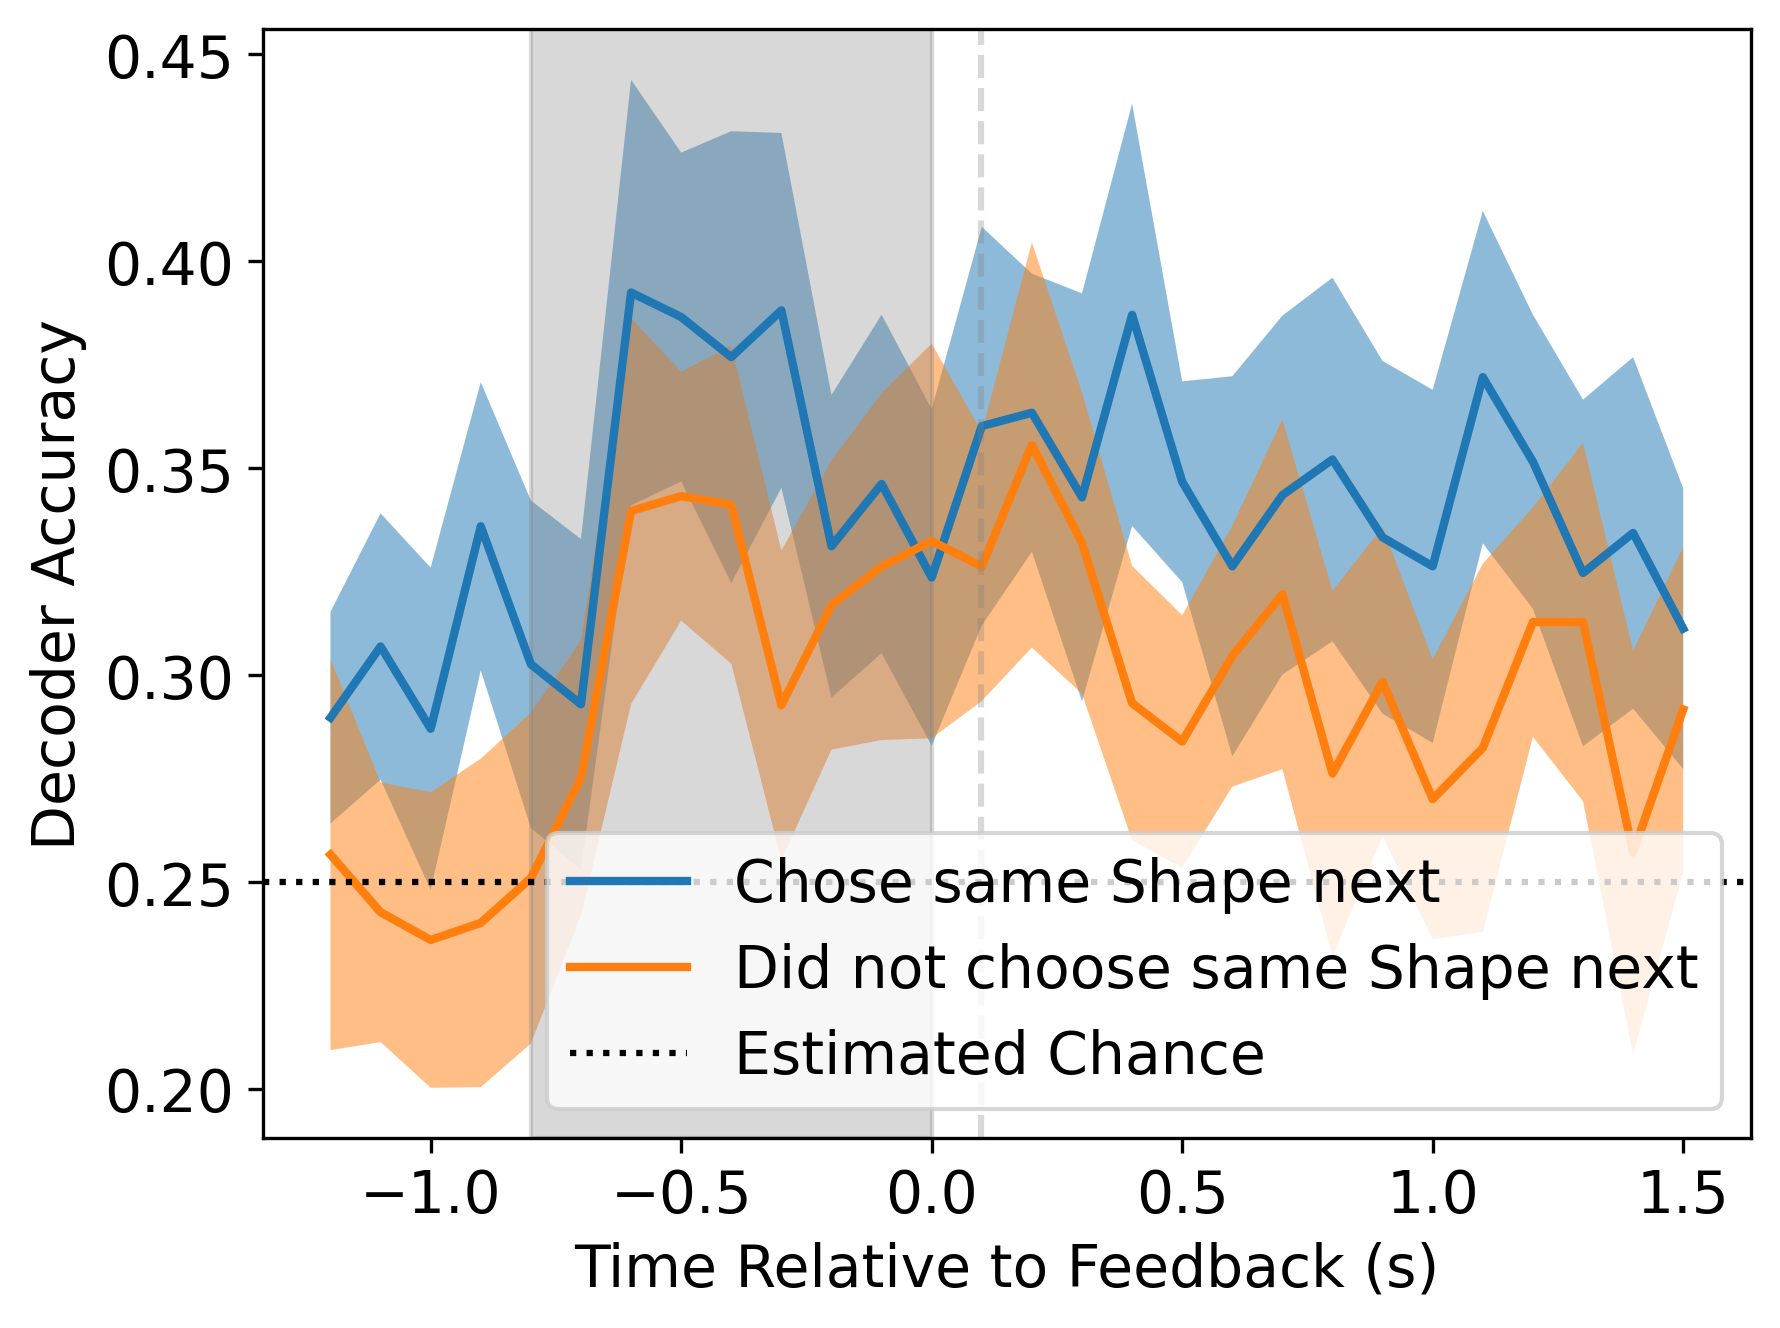

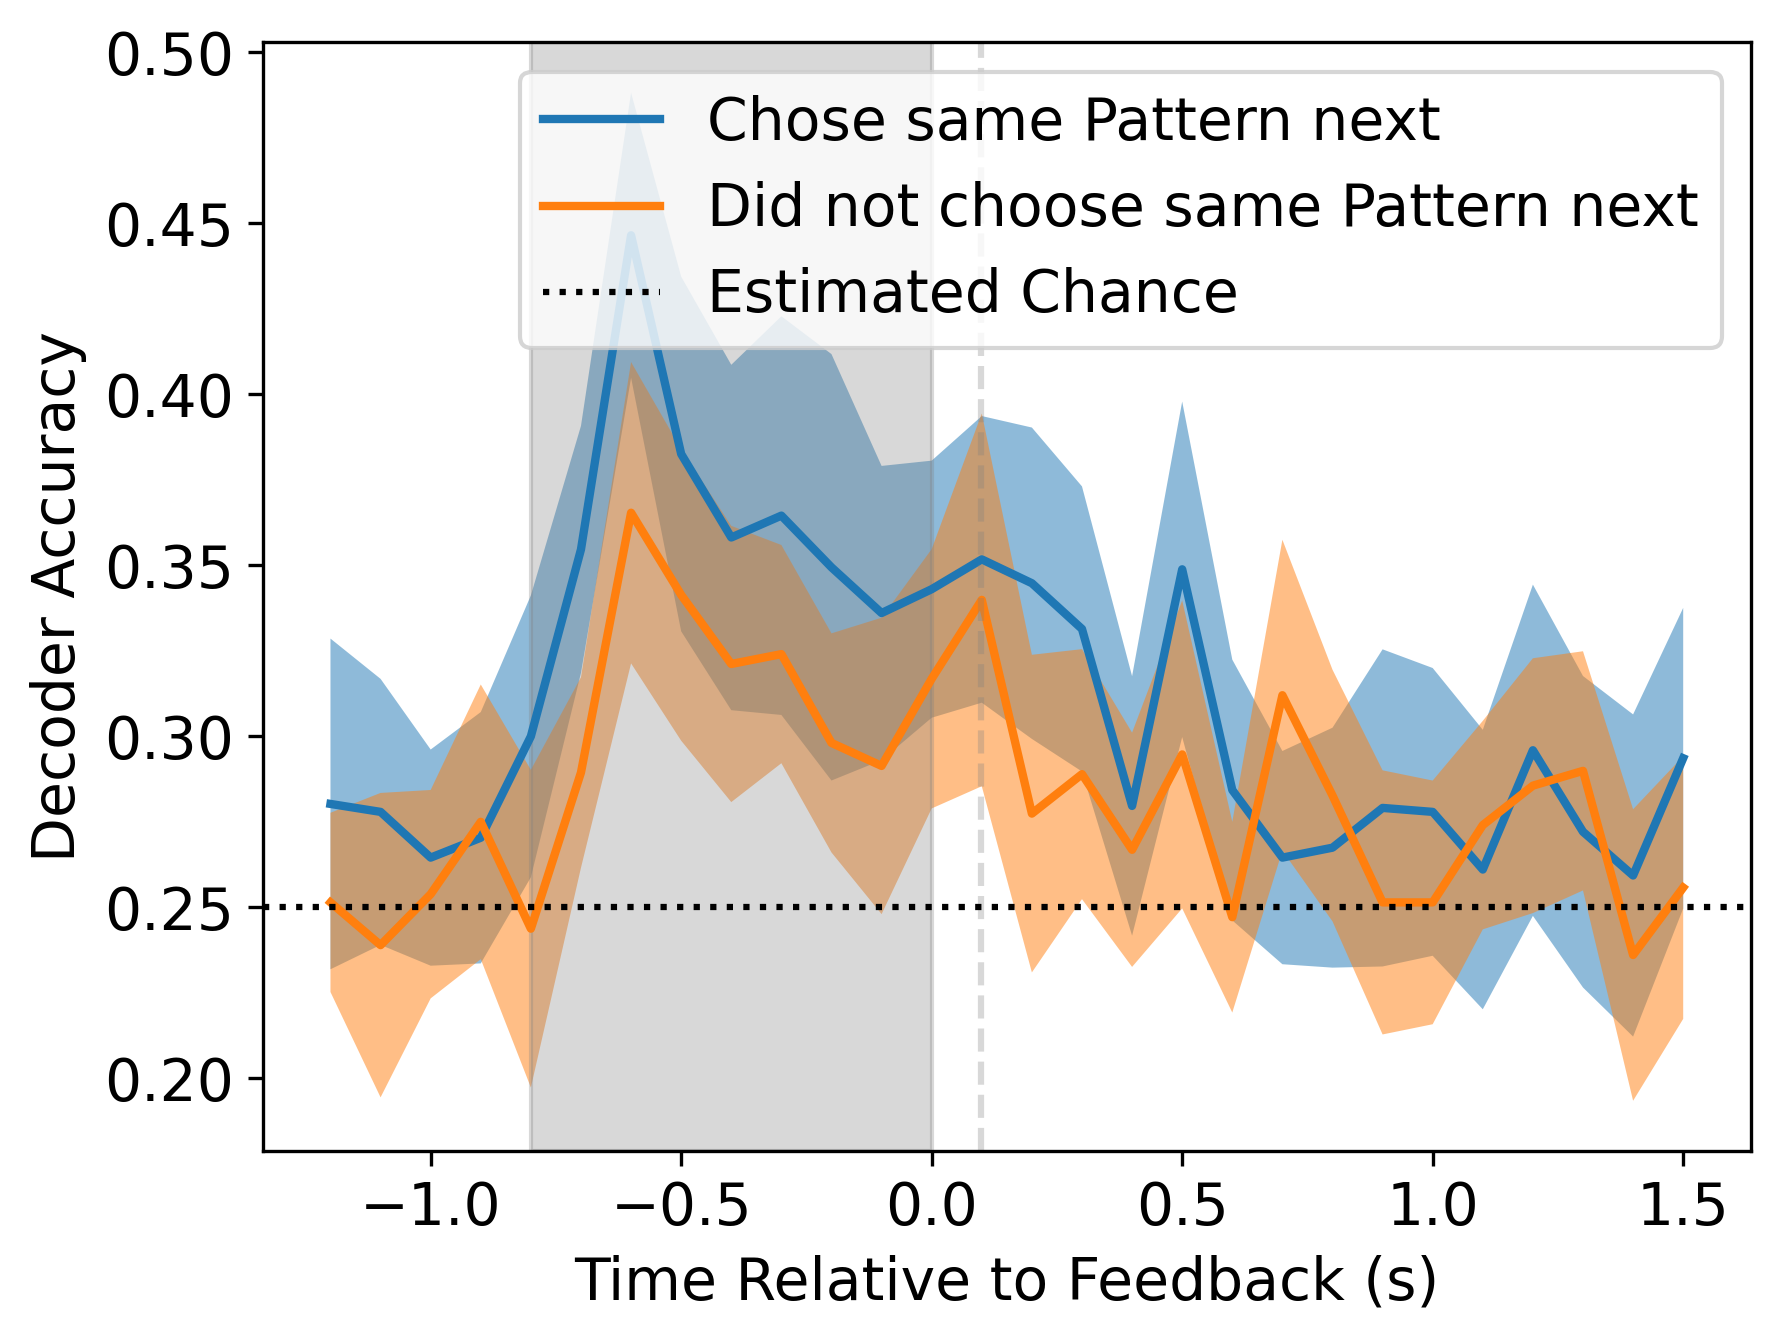

In [6]:
for feature_dim in feature_dims:
    _, chose_next_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_chose_next", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )
    _, not_chose_next_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_not_chose_next", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        chose_next_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"Chose same {feature_dim} next",
        right_align=True, 
        # color='black'
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        not_chose_next_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"Did not choose same {feature_dim} next",
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Split corrects by whether feature chosen on next trial (KFold Block splitter)

In [ ]:
for feature_dim in feature_dims:
    chose_next_fs = sub_fs_w_next[sub_fs_w_next[feature_dim] == sub_fs_w_next[f"Next{feature_dim}"]]
    not_chose_next_fs = sub_fs_w_next[sub_fs_w_next[feature_dim] != sub_fs_w_next[f"Next{feature_dim}"]]

    beh_chose_next = valid_beh[valid_beh.TrialNumber.isin(chose_next_fs.TrialNumber)]
    beh_not_chose_next = valid_beh[valid_beh.TrialNumber.isin(not_chose_next_fs.TrialNumber)]

    chose_next_frs = firing_rates[firing_rates.TrialNumber.isin(chose_next_fs.TrialNumber)]
    not_chose_next_frs = firing_rates[firing_rates.TrialNumber.isin(not_chose_next_fs.TrialNumber)]

    train_model(
        feature_dim, chose_next_frs, chose_next_fs, 
        1300, 1500, 100, f"{feature_dim}_chose_next", "fb",
        KFoldBlockSplitter(beh_chose_next, 10), "kfold_block_split"
    )
    train_model(
        feature_dim, not_chose_next_frs, not_chose_next_fs, 
        1300, 1500, 100, f"{feature_dim}_not_chose_next", "fb",
        KFoldBlockSplitter(beh_not_chose_next, 10), "kfold_block_split"
    )   

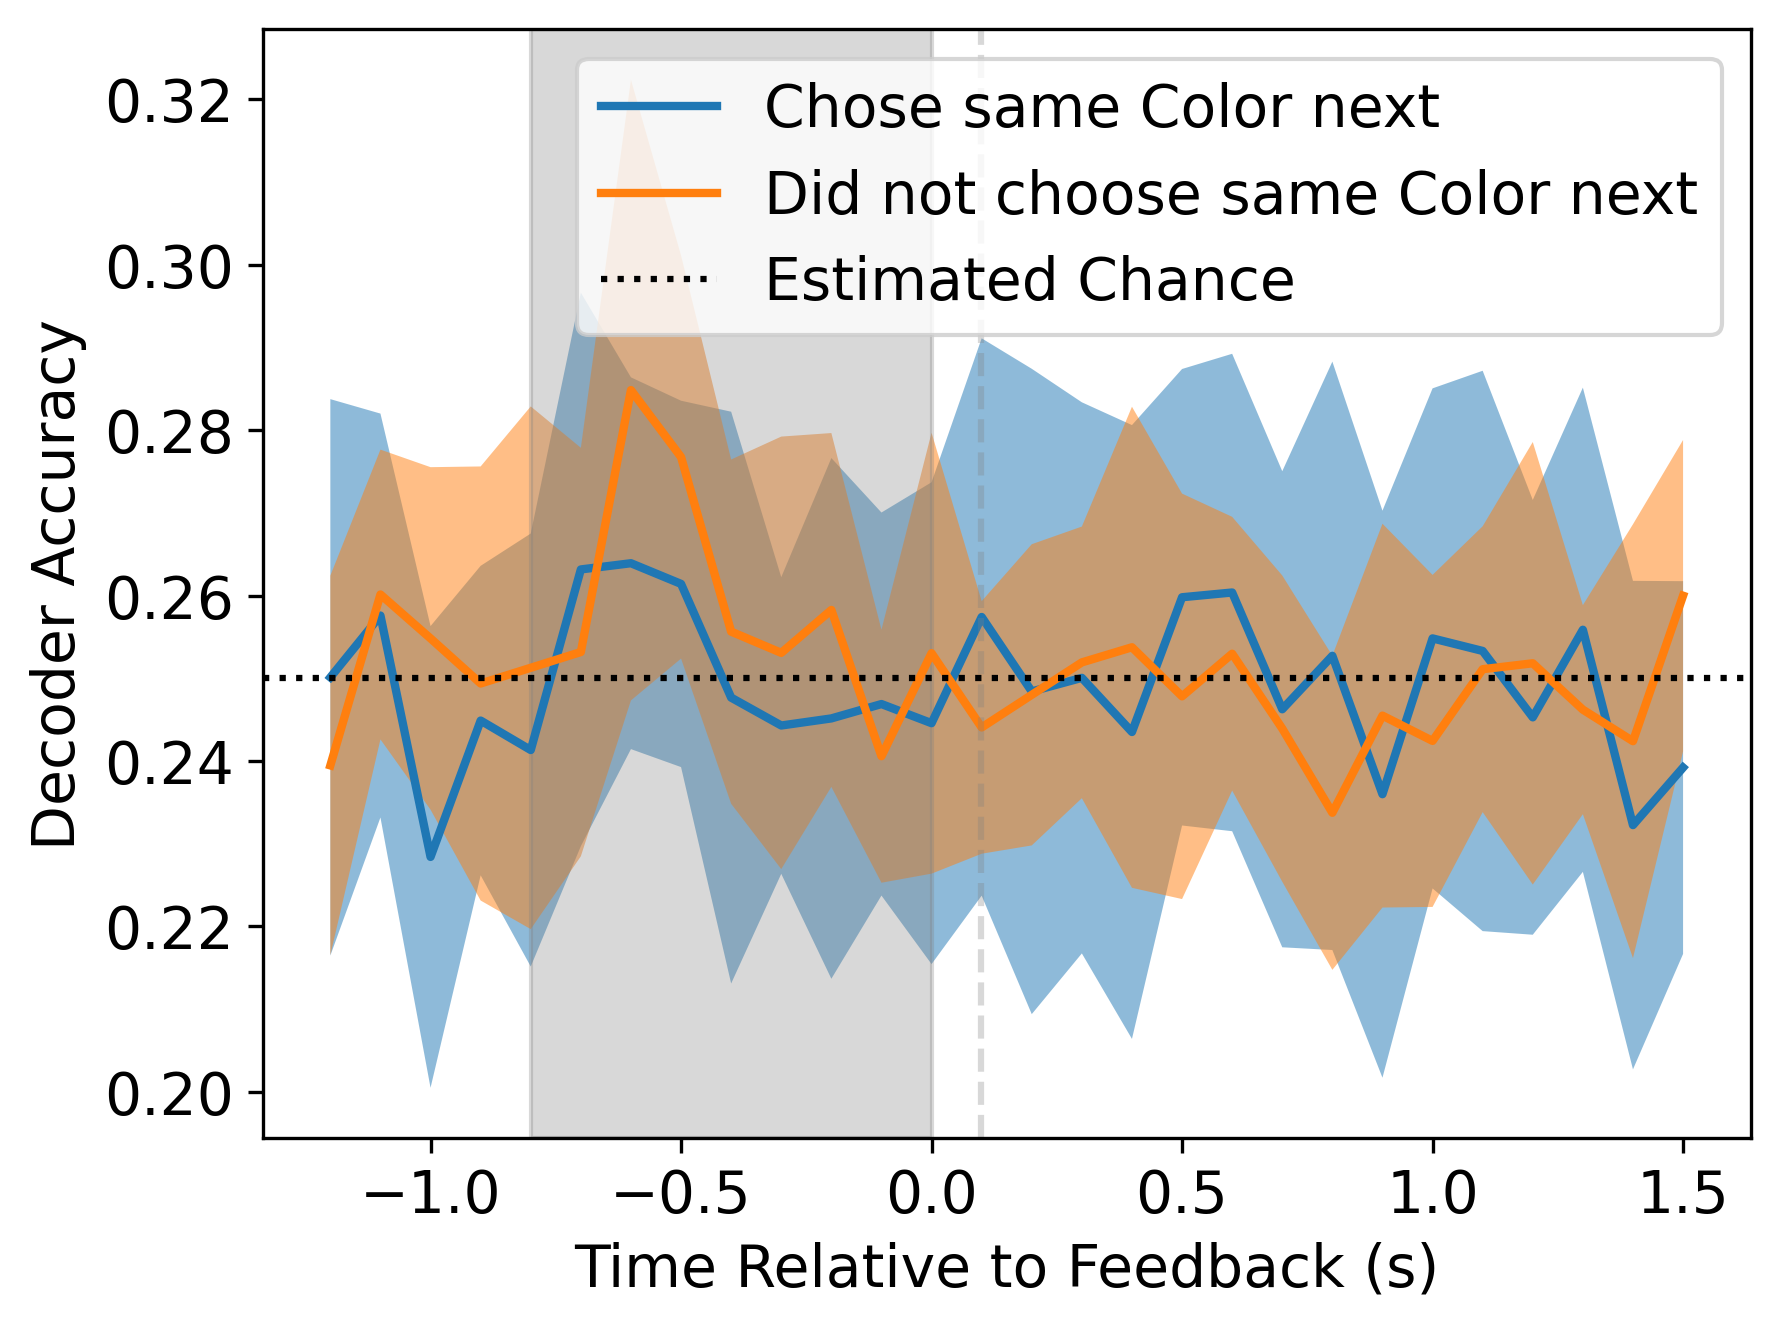

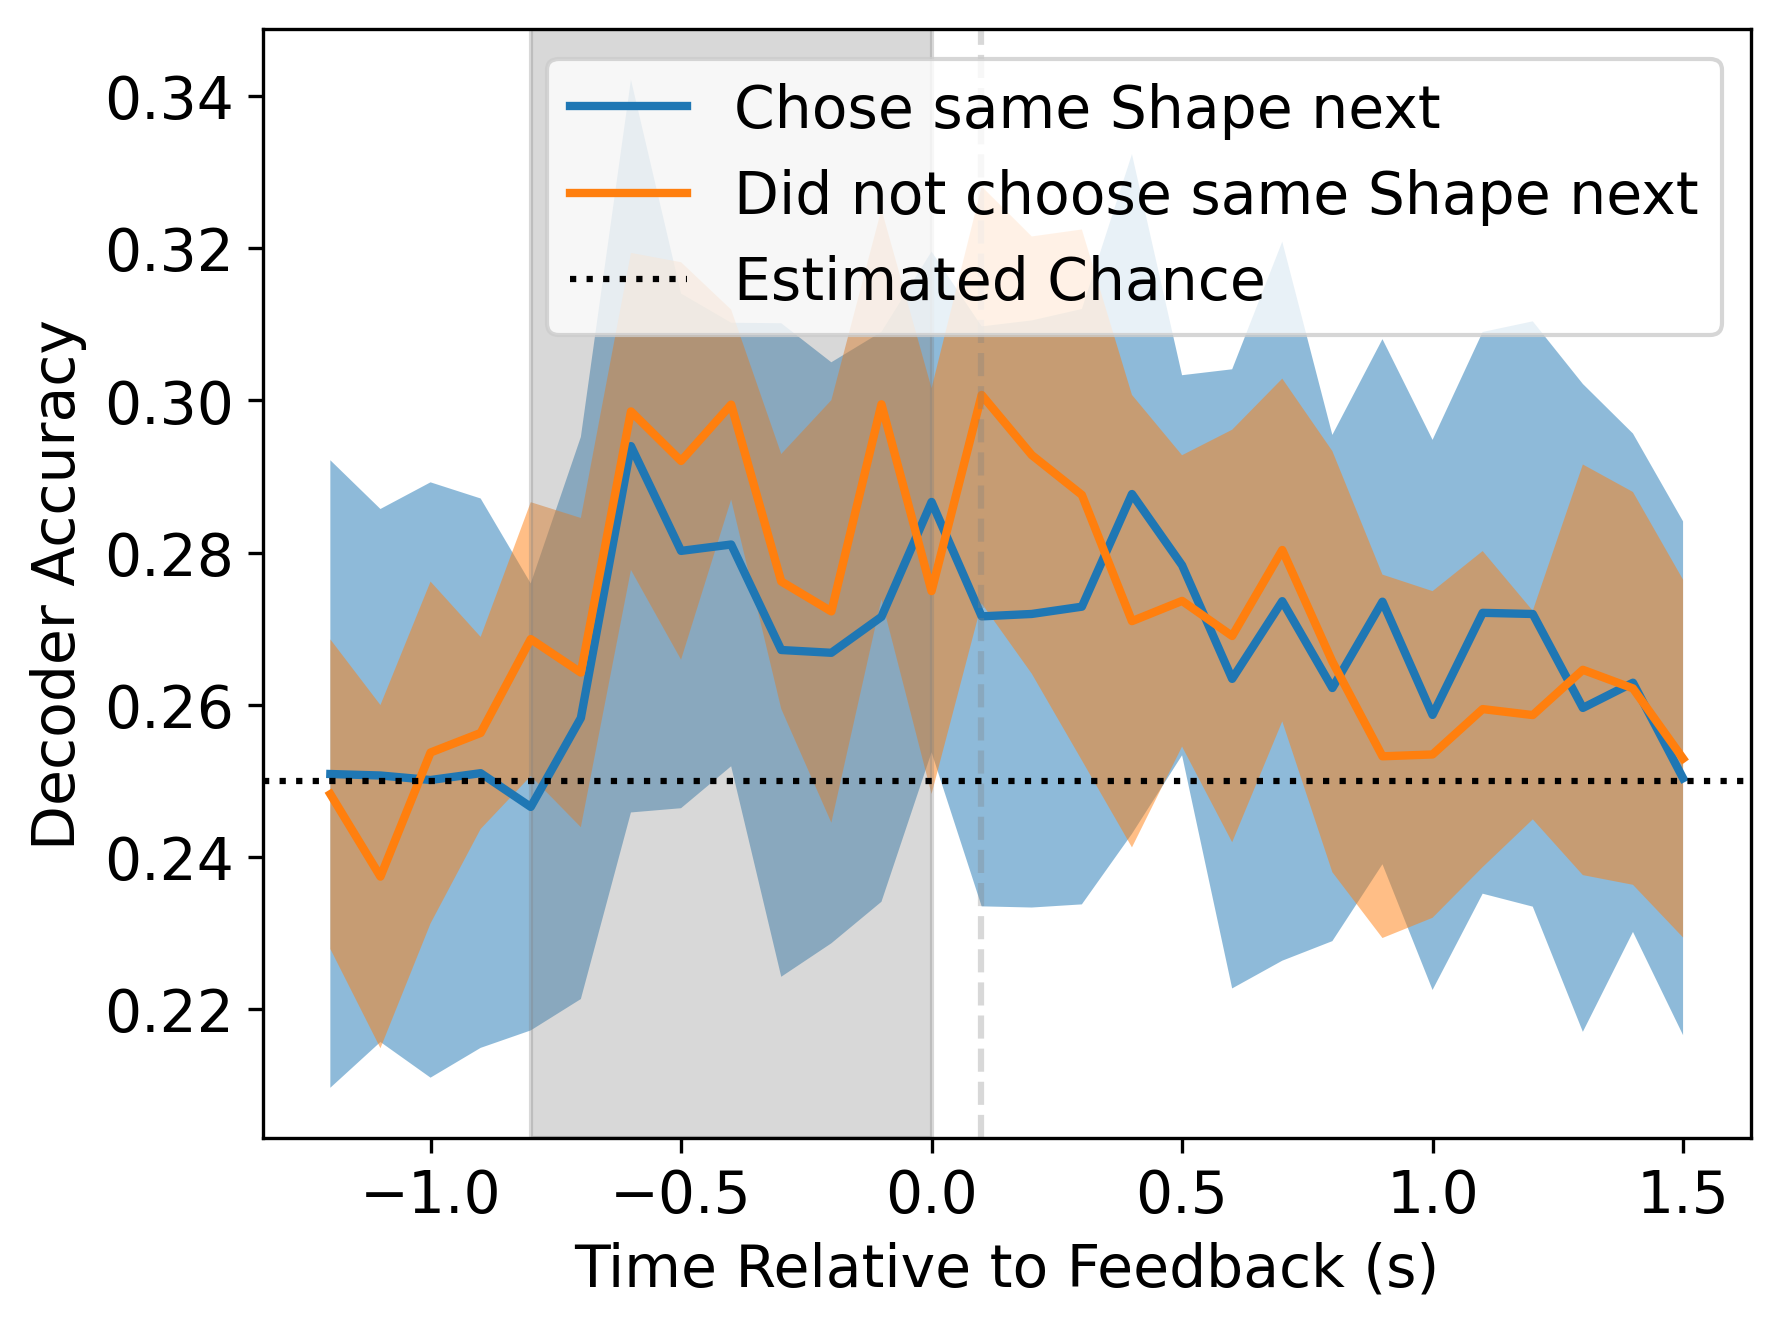

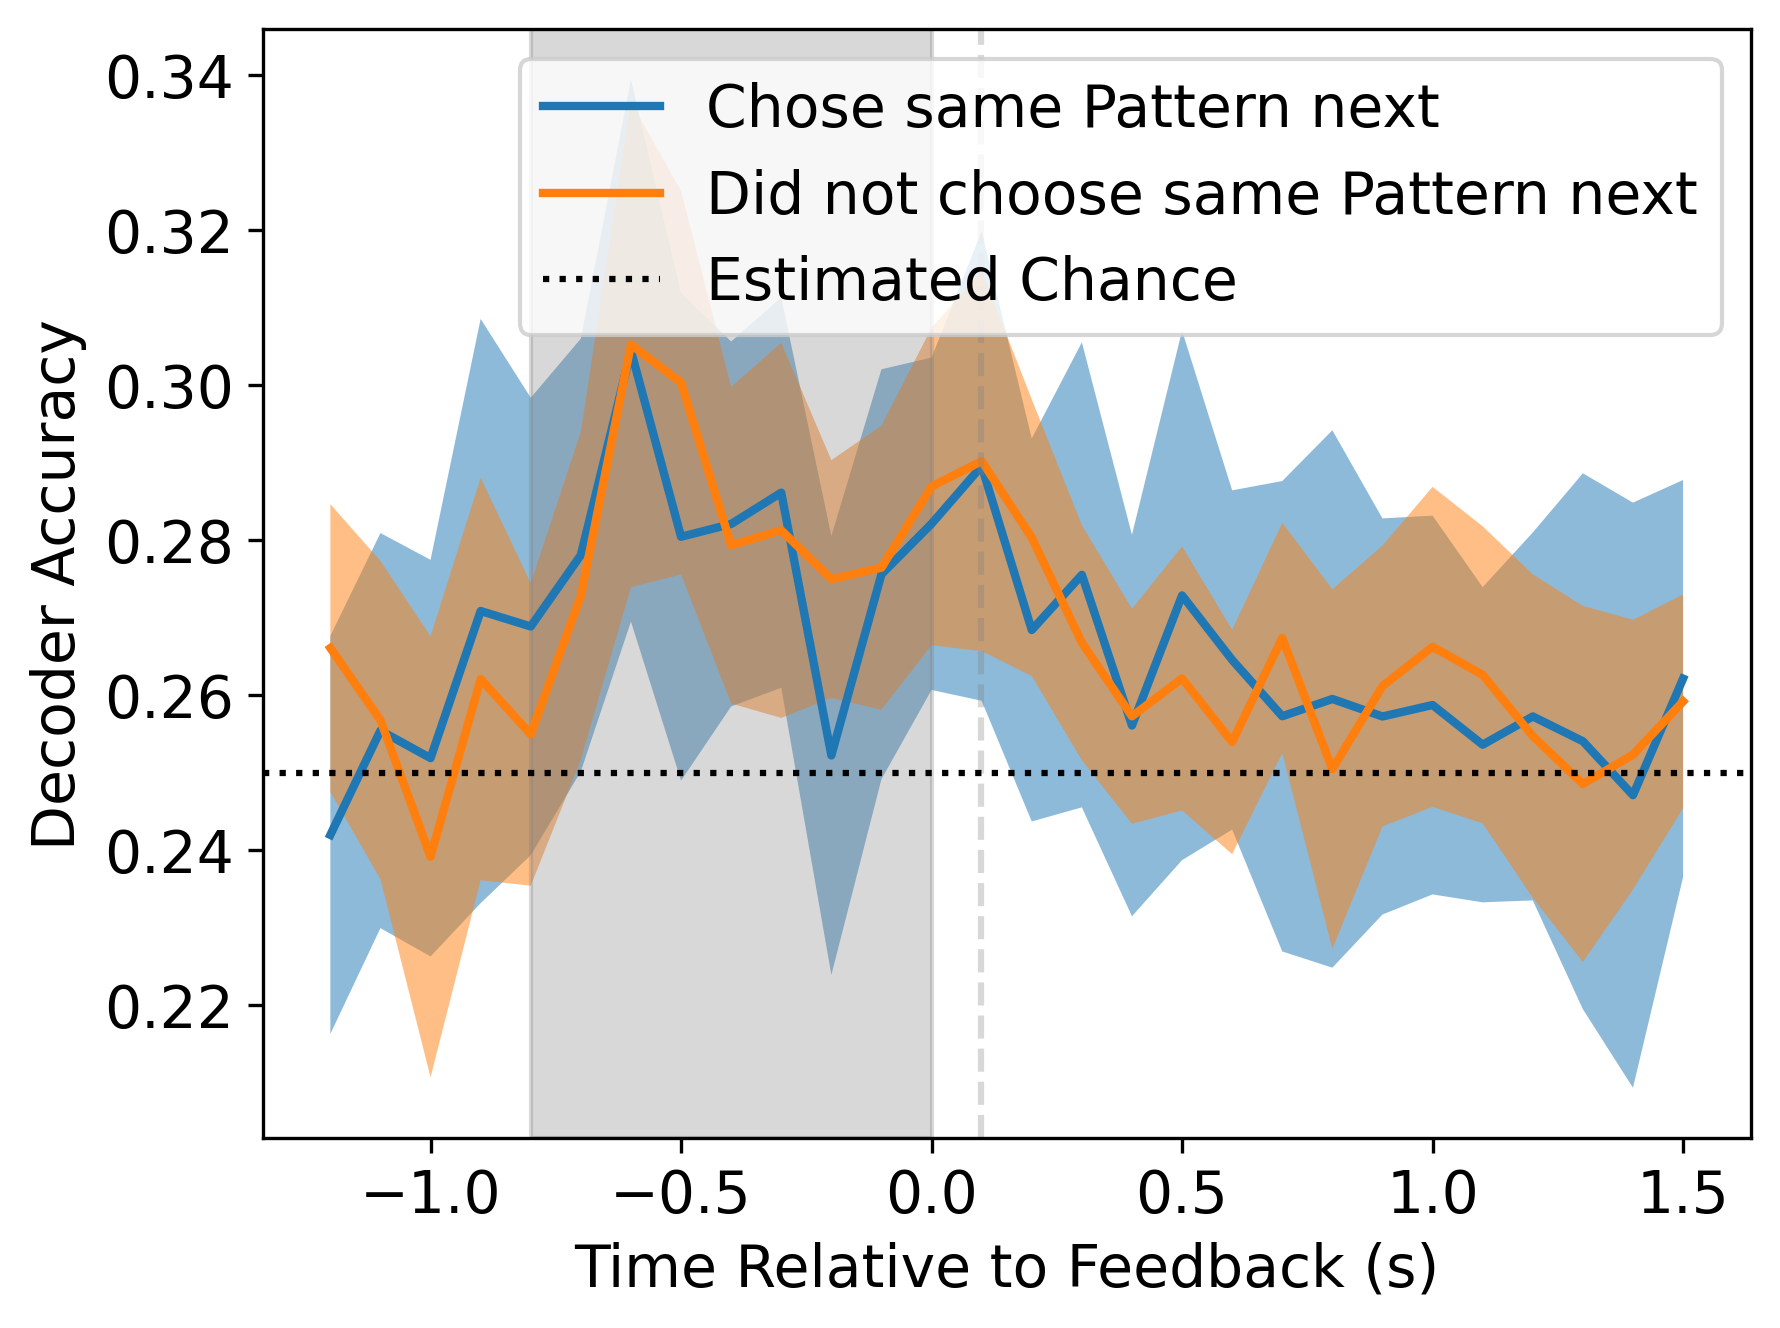

In [6]:
for feature_dim in feature_dims:
    _, chose_next_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_chose_next", 
        f"{pre_interval}_fb_{post_interval}",
        "kfold_block_split",
    )
    _, not_chose_next_accs, _, _, _ = io_utils.load_model_outputs(
        f"{feature_dim}_not_chose_next", 
        f"{pre_interval}_fb_{post_interval}",
        "kfold_block_split",
    )

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        chose_next_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"Chose same {feature_dim} next",
        right_align=True, 
        # color='black'
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        not_chose_next_accs,
        1.3, 1.5, 0.1,
        ax,
        label=f"Did not choose same {feature_dim} next",
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})